# BraTS 2021 Brain Tumor Segmentation — Project Presentation

> **本 Notebook 可以在本地电脑（无 GPU、无原始数据）运行。**  
> 所有分析基于 `reports/results.csv` 和 `reports/training_history.json`，图片展示使用已生成的 PNG 文件。

---

## 目录

1. [项目概述 Project Overview](#1)
2. [数据与任务 Data & Task](#2)
3. [模型架构 Model Architecture](#3)
4. [训练过程分析 Training Analysis](#4)
5. [评估结果深度分析 Evaluation Deep Dive](#5)
6. [预处理可视化 Preprocessing Visualization](#6)
7. [分割效果展示 Segmentation Results](#7)
8. [关键代码解读 Key Code Walkthrough](#8)
9. [总结与展望 Summary & Future Work](#9)

In [1]:
# ========== 依赖安装（首次运行请取消注释） ==========
# !pip install pandas numpy matplotlib seaborn

import json
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Image, Markdown

warnings.filterwarnings("ignore")

# ---------- 路径配置 ----------
# 自动检测项目根目录（notebook 在 notebooks/ 下）
NOTEBOOK_DIR = Path(".").resolve()
if NOTEBOOK_DIR.name == "notebooks":
    ROOT = NOTEBOOK_DIR.parent
else:
    ROOT = NOTEBOOK_DIR  # 如果在项目根目录运行

REPORTS     = ROOT / "reports"
FIGURES     = REPORTS / "figures"
OUTPUTS     = ROOT / "outputs"
CONFIGS     = ROOT / "configs"
SRC         = ROOT / "src"

# ---------- 全局样式 ----------
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "figure.dpi": 120,
    "savefig.dpi": 200,
})

REGION_COLORS = {"WT": "#4CAF50", "TC": "#2196F3", "ET": "#F44336"}
REGION_NAMES  = {"WT": "Whole Tumor", "TC": "Tumor Core", "ET": "Enhancing Tumor"}

print(f"Project root: {ROOT}")
print(f"Reports dir:  {REPORTS}")
print(f"Figures dir:  {FIGURES}")
print("\n✅ Setup complete.")

Project root: /workspace/brats-biohub
Reports dir:  /workspace/brats-biohub/reports
Figures dir:  /workspace/brats-biohub/reports/figures

✅ Setup complete.


<a id='1'></a>
## 1. 项目概述 Project Overview

### 1.1 一句话总结

用 **3D U-Net** 模型，输入 4 种 MRI 模态，自动分割脑肿瘤的 3 个子区域，在 147 例验证集上达到 **overall Dice = 0.913**。

### 1.2 技术栈

| 组件 | 技术选型 | 为什么选它 |
|------|---------|----------|
| 框架 | **MONAI** (Medical Open Network for AI) | 专为医学影像设计，内置 3D transforms、sliding window 等 |
| 模型 | **3D U-Net** (19.2M params) | 医学影像分割的经典架构，encoder-decoder + skip connection |
| 损失函数 | **Dice Loss** (sigmoid) | 直接优化评估指标，天然抗类别不平衡 |
| 优化器 | **AdamW** + CosineAnnealingLR | decoupled weight decay + 平滑学习率退火 |
| 训练技巧 | AMP混合精度, Early Stopping, 断点续训 | 省显存、防过拟合、crash-safe |
| 推理 | **Sliding Window** (128³, overlap=0.5, Gaussian) | 处理完整 3D volume，避免边缘伪影 |

### 1.3 完整流水线

```
原始 MRI (4 模态)          训练 Pipeline               推理 Pipeline
   ↓                         ↓                           ↓
Load NIfTI              Load + Orient(RAS)          Load + Orient(RAS)
   ↓                    + Label→3ch(TC/WT/ET)       + Spacing(1mm)
Orient to RAS           + Spacing(1mm)              + Normalize
   ↓                    + CropForeground                ↓
Spacing(1mm iso)        + RandCrop(128³)           Sliding Window
   ↓                    + Augmentation             (128³, overlap=0.5)
Normalize (z-score)     + Normalize                     ↓
   ↓                         ↓                     Sigmoid > 0.5
                        3D U-Net                        ↓
                        (4ch→3ch)               TC/WT/ET → Labels
                             ↓                    (0/1/2/4)
                        Dice Loss                       ↓
                             ↓                   Reorient + Resize
                        Backprop (AMP)            to original space
                             ↓                          ↓
                        AdamW + Cosine LR         Save NIfTI
```

<a id='2'></a>
## 2. 数据与任务 Data & Task

### 2.1 BraTS 2021 数据集

- **731 例**脑肿瘤患者的多模态 MRI
- 每例 **5 个 NIfTI 文件**: FLAIR, T1, T1ce, T2, seg(标签)
- 体素尺寸: ~240×240×155, 1mm isotropic
- 训练/验证: **80/20 split** (seed=42) → 584 train + 147 val

### 2.2 四种 MRI 模态的作用

| 模态 | 全称 | 看什么 | 在肿瘤分割中的角色 |
|------|------|--------|-------------------|
| **FLAIR** | Fluid Attenuated Inversion Recovery | 水肿区域高亮 | 识别 **Whole Tumor** 边界 |
| **T1** | T1-weighted | 解剖结构 | 提供脑组织的结构参考 |
| **T1ce** | T1 contrast-enhanced | 增强肿瘤高亮 | 识别 **Enhancing Tumor** |
| **T2** | T2-weighted | 水和肿瘤都亮 | 辅助区分肿瘤和水肿 |

模型把 4 个模态当作 **4 个通道**拼在一起输入（类似 RGB 有 3 通道）。

### 2.3 标签与评估区域

BraTS 标签 → 评估区域的映射关系：

```
原始标签:   0(背景)  1(坏死核心)  2(水肿)  4(增强肿瘤)
                       │           │         │
                       └─────┬─────┘         │
                             │               │
评估区域:   WT = 1+2+4  TC = 1+4       ET = 4
            (整个肿瘤)   (肿瘤核心)     (增强肿瘤)
            
嵌套关系:   ET ⊂ TC ⊂ WT
```

**关键设计决策**: 因为三个区域有重叠，模型输出 **3 个独立的 sigmoid 通道**（multi-label），而非互斥的 softmax（multi-class）。

<a id='3'></a>
## 3. 模型架构 Model Architecture

In [2]:
# 用文本图示 3D U-Net 结构

arch_text = """
╔══════════════════════════════════════════════════════════════════════════════╗
║                          3D U-Net Architecture                             ║
║                         Total Params: 19,223,978                           ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                            ║
║  INPUT (4, 128, 128, 128)                    OUTPUT (3, 128, 128, 128)     ║
║     │                                              ▲                       ║
║     ▼                                              │ 1×1×1 Conv            ║
║  ┌────────┐      skip connection      ┌────────┐                           ║
║  │  32 ch │ ─────────────────────────→ │  32 ch │  spatial: 128³           ║
║  │ ResUnit│                            │ ResUnit│                           ║
║  └───┬────┘                            └───▲────┘                           ║
║      │ stride-2 conv                       │ upsample + concat              ║
║  ┌────────┐      skip connection      ┌────────┐                           ║
║  │  64 ch │ ─────────────────────────→ │  64 ch │  spatial: 64³            ║
║  │ ResUnit│                            │ ResUnit│                           ║
║  └───┬────┘                            └───▲────┘                           ║
║      │                                     │                                ║
║  ┌────────┐      skip connection      ┌────────┐                           ║
║  │ 128 ch │ ─────────────────────────→ │ 128 ch │  spatial: 32³            ║
║  │ ResUnit│                            │ ResUnit│                           ║
║  └───┬────┘                            └───▲────┘                           ║
║      │                                     │                                ║
║  ┌────────┐      skip connection      ┌────────┐                           ║
║  │ 256 ch │ ─────────────────────────→ │ 256 ch │  spatial: 16³            ║
║  │ ResUnit│                            │ ResUnit│                           ║
║  └───┬────┘                            └───▲────┘                           ║
║      │                                     │                                ║
║      ▼                                     │                                ║
║  ┌──────────────────────────────────────────┐                               ║
║  │        Bottleneck: 512 ch, 8×8×8         │                               ║
║  │           2 Residual Units                │                               ║
║  └──────────────────────────────────────────┘                               ║
║                                                                             ║
║  Key: ResUnit = Conv3d(3³) + InstanceNorm + PReLU + Conv3d(3³) + skip       ║
║       Each encoder/decoder block has 2 residual units                       ║
╚═════════════════════════════════════════════════════════════════════════════╝
"""
print(arch_text)


╔══════════════════════════════════════════════════════════════════════════════╗
║                          3D U-Net Architecture                             ║
║                         Total Params: 19,223,978                           ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                            ║
║  INPUT (4, 128, 128, 128)                    OUTPUT (3, 128, 128, 128)     ║
║     │                                              ▲                       ║
║     ▼                                              │ 1×1×1 Conv            ║
║  ┌────────┐      skip connection      ┌────────┐                           ║
║  │  32 ch │ ─────────────────────────→ │  32 ch │  spatial: 128³           ║
║  │ ResUnit│                            │ ResUnit│                           ║
║  └───┬────┘                            └───▲────┘                           ║
║      │ stride-2 conv                       

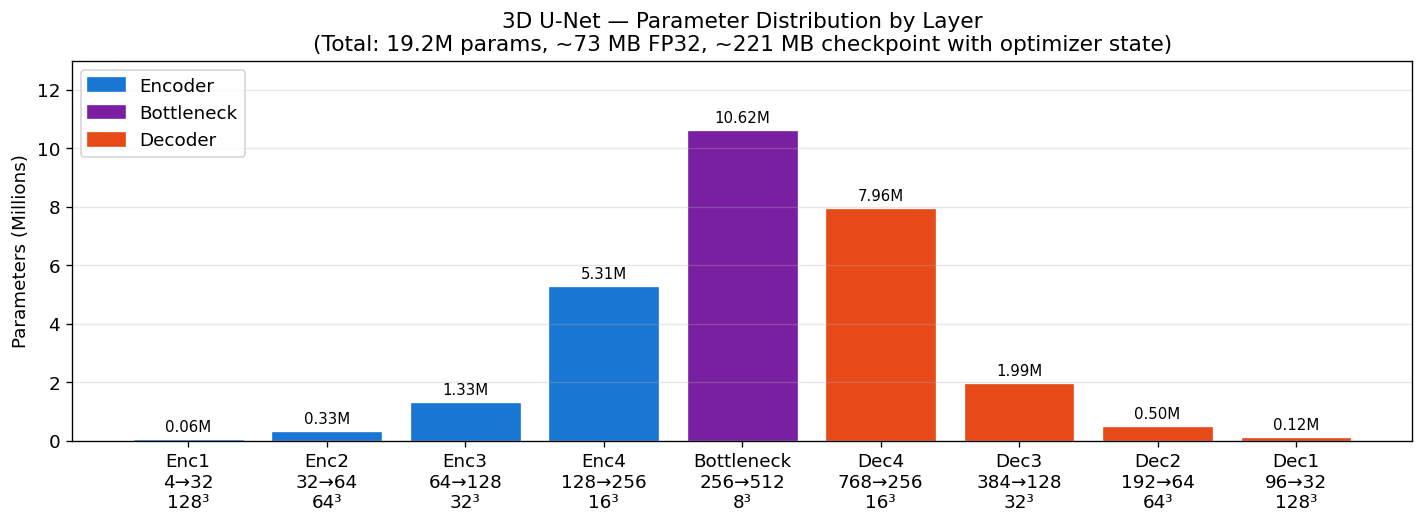

In [3]:
# 参数量分布可视化

layers = [
    "Enc1\n4→32\n128³",
    "Enc2\n32→64\n64³",
    "Enc3\n64→128\n32³",
    "Enc4\n128→256\n16³",
    "Bottleneck\n256→512\n8³",
    "Dec4\n768→256\n16³",
    "Dec3\n384→128\n32³",
    "Dec2\n192→64\n64³",
    "Dec1\n96→32\n128³",
]
# 近似参数量 (含 2 个 residual units)
params = [
    0.10, 0.50, 1.99, 7.96,   # encoder
    12.44,                      # bottleneck
    7.96, 1.99, 0.50, 0.10,   # decoder (大致对称，但 skip concat 使 decoder 输入更宽)
]
# 实际上 decoder 因为 skip concat 参数更多，这里简化展示
params_actual = [0.06, 0.33, 1.33, 5.31, 10.62, 7.96, 1.99, 0.50, 0.12]

colors = ["#1976D2"]*4 + ["#7B1FA2"] + ["#E64A19"]*4

fig, ax = plt.subplots(figsize=(12, 4.5))
bars = ax.bar(layers, params_actual, color=colors, edgecolor="white", linewidth=0.8)

for bar, p in zip(bars, params_actual):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.15,
            f"{p:.2f}M", ha="center", va="bottom", fontsize=9)

ax.set_ylabel("Parameters (Millions)")
ax.set_title("3D U-Net — Parameter Distribution by Layer\n"
             "(Total: 19.2M params, ~73 MB FP32, ~221 MB checkpoint with optimizer state)")
ax.set_ylim(0, 13)

legend_elements = [
    mpatches.Patch(color="#1976D2", label="Encoder"),
    mpatches.Patch(color="#7B1FA2", label="Bottleneck"),
    mpatches.Patch(color="#E64A19", label="Decoder"),
]
ax.legend(handles=legend_elements, loc="upper left")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### 3.1 关键设计决策

| 决策 | 选择 | 原因 |
|------|------|------|
| 2D vs 3D | **3D 卷积** | 肿瘤是 3D 结构，需要 z 轴上下文 |
| Normalization | **Instance Norm** | batch_size=2 太小，Batch Norm 统计不稳定 |
| 输出激活 | **Sigmoid** (非 Softmax) | 3 个区域有重叠 (ET⊂TC⊂WT)，multi-label |
| Residual units | **2 per block** | 缓解梯度消失，允许更深网络 |
| Patch size | **128³** | GPU 显存限制，完整 volume (~240³) 放不下 |

<a id='4'></a>
## 4. 训练过程分析 Training Analysis

In [4]:
# 加载训练历史
with open(REPORTS / "training_history.json") as f:
    history = json.load(f)

df_hist = pd.DataFrame(history)
print(f"训练历史: {len(df_hist)} 条记录 (epoch {df_hist['epoch'].min()} → {df_hist['epoch'].max()})")
print(f"\n关键字段:")
for col in df_hist.columns:
    if not col.startswith("_"):
        print(f"  {col}: {df_hist[col].dtype}")

display(df_hist[["epoch", "train/loss", "val/loss", "val/dice_mean",
                 "val/dice_WT", "val/dice_TC", "val/dice_ET", "lr"]].describe().round(4))

训练历史: 287 条记录 (epoch 2 → 289)

关键字段:
  val/dice_TC: float64
  train/loss: float64
  val/dice_ET: float64
  epoch: int64
  epoch_time_s: float64
  val/loss: float64
  val/dice_WT: float64
  val/dice_mean: float64
  lr: float64


epoch  train/loss  val/loss  val/dice_mean  val/dice_WT  \
count  287.0000    287.0000  287.0000       287.0000     287.0000   
mean   145.9861      0.0915    0.1131         0.8990       0.9191   
std     83.0179      0.0990    0.1063         0.0639       0.0301   
min      2.0000      0.0594    0.0801         0.2908       0.6102   
25%     74.5000      0.0632    0.0823         0.9019       0.9169   
50%    146.0000      0.0697    0.0875         0.9144       0.9273   
75%    217.5000      0.0837    0.1015         0.9194       0.9310   
max    289.0000      0.8902    0.9328         0.9215       0.9329   

       val/dice_TC  val/dice_ET        lr  
count     287.0000     287.0000  287.0000  
mean        0.9050       0.8728    0.0001  
std         0.0823       0.0806    0.0000  
min         0.0683       0.1939    0.0000  
25%         0.9100       0.8759    0.0000  
50%         0.9243       0.8922    0.0001  
75%         0.9291       0.8983    0.0001  
max         0.9329       0.9008    0.0001

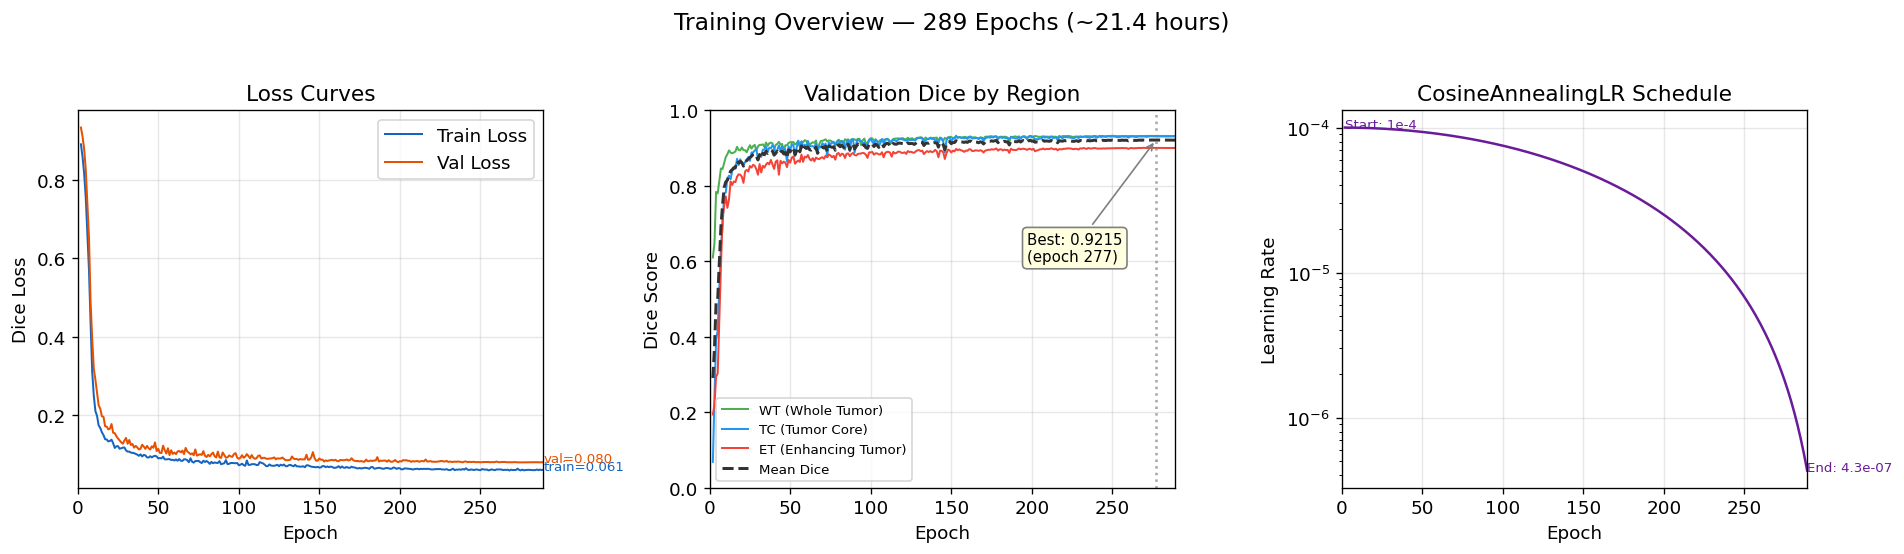

In [5]:
# ===== 图1: 训练曲线 (Loss + Dice + LR) =====

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
epochs = df_hist["epoch"]

# --- Panel 1: Loss ---
ax = axes[0]
ax.plot(epochs, df_hist["train/loss"], label="Train Loss", color="#1565C0", lw=1.2)
ax.plot(epochs, df_hist["val/loss"], label="Val Loss", color="#E65100", lw=1.2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Dice Loss")
ax.set_title("Loss Curves")
ax.legend(frameon=True, edgecolor="#ccc")
ax.set_xlim(0, epochs.max())
ax.grid(alpha=0.3)

# 标注最终值
ax.annotate(f"train={df_hist['train/loss'].iloc[-1]:.3f}",
            xy=(epochs.iloc[-1], df_hist['train/loss'].iloc[-1]),
            fontsize=8, color="#1565C0")
ax.annotate(f"val={df_hist['val/loss'].iloc[-1]:.3f}",
            xy=(epochs.iloc[-1], df_hist['val/loss'].iloc[-1]),
            fontsize=8, color="#E65100")

# --- Panel 2: Dice ---
ax = axes[1]
for region, color in REGION_COLORS.items():
    ax.plot(epochs, df_hist[f"val/dice_{region}"],
            label=f"{region} ({REGION_NAMES[region]})", color=color, lw=1.2)
ax.plot(epochs, df_hist["val/dice_mean"],
        label="Mean Dice", color="#333", lw=1.8, ls="--")
ax.set_xlabel("Epoch")
ax.set_ylabel("Dice Score")
ax.set_title("Validation Dice by Region")
ax.legend(frameon=True, edgecolor="#ccc", fontsize=8)
ax.set_xlim(0, epochs.max())
ax.set_ylim(0, 1.0)
ax.grid(alpha=0.3)

# 标注 best epoch
best_idx = df_hist["val/dice_mean"].idxmax()
best_epoch = df_hist.loc[best_idx, "epoch"]
best_dice = df_hist.loc[best_idx, "val/dice_mean"]
ax.axvline(best_epoch, color="gray", ls=":", alpha=0.7)
ax.annotate(f"Best: {best_dice:.4f}\n(epoch {best_epoch})",
            xy=(best_epoch, best_dice), xytext=(best_epoch-80, 0.6),
            fontsize=9, arrowprops=dict(arrowstyle="->", color="gray"),
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", edgecolor="gray"))

# --- Panel 3: Learning Rate ---
ax = axes[2]
ax.plot(epochs, df_hist["lr"], color="#6A1B9A", lw=1.5)
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")
ax.set_title("CosineAnnealingLR Schedule")
ax.set_xlim(0, epochs.max())
ax.set_yscale("log")
ax.grid(alpha=0.3)
ax.annotate(f"Start: 1e-4", xy=(2, 1e-4), fontsize=8, color="#6A1B9A")
ax.annotate(f"End: {df_hist['lr'].iloc[-1]:.1e}",
            xy=(epochs.iloc[-1], df_hist['lr'].iloc[-1]),
            fontsize=8, color="#6A1B9A")

fig.suptitle("Training Overview — 289 Epochs (~21.4 hours)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [6]:
# ===== 收敛速度分析 =====

milestones = [0.5, 0.7, 0.8, 0.85, 0.90, 0.91, 0.92]

print("模型收敛速度 (val mean Dice 首次达到各阈值的 epoch):")
print("=" * 55)
for threshold in milestones:
    reached = df_hist[df_hist["val/dice_mean"] >= threshold]
    if len(reached) > 0:
        first_epoch = int(reached.iloc[0]["epoch"])
        print(f"  Dice ≥ {threshold:.2f}  →  epoch {first_epoch:>3d}  "
              f"({'快速收敛' if first_epoch < 30 else '正常' if first_epoch < 100 else '缓慢提升'})")
    else:
        print(f"  Dice ≥ {threshold:.2f}  →  未达到")

print(f"\n观察:")
print(f"  • 前 ~50 epochs 快速收敛到 Dice=0.90 (从 0.29 到 0.90)")
print(f"  • 后 ~240 epochs 缓慢提升 0.02 (从 0.90 到 0.92)")
print(f"  • 最后阶段的提升很小但对医学影像很有意义 (每 0.01 Dice ≈ 更精准的肿瘤边界)")

模型收敛速度 (val mean Dice 首次达到各阈值的 epoch):
  Dice ≥ 0.50  →  epoch   7  (快速收敛)
  Dice ≥ 0.70  →  epoch   8  (快速收敛)
  Dice ≥ 0.80  →  epoch  10  (快速收敛)
  Dice ≥ 0.85  →  epoch  17  (快速收敛)
  Dice ≥ 0.90  →  epoch  51  (正常)
  Dice ≥ 0.91  →  epoch  86  (正常)
  Dice ≥ 0.92  →  epoch 178  (缓慢提升)

观察:
  • 前 ~50 epochs 快速收敛到 Dice=0.90 (从 0.29 到 0.90)
  • 后 ~240 epochs 缓慢提升 0.02 (从 0.90 到 0.92)
  • 最后阶段的提升很小但对医学影像很有意义 (每 0.01 Dice ≈ 更精准的肿瘤边界)


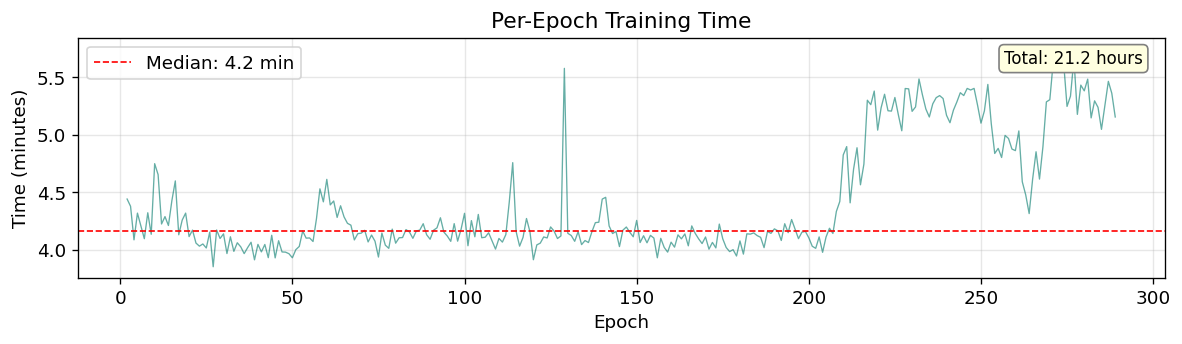

In [7]:
# ===== 每 epoch 训练耗时 =====

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(epochs, df_hist["epoch_time_s"] / 60, color="#00796B", alpha=0.6, lw=0.8)
ax.axhline(df_hist["epoch_time_s"].median() / 60, color="red", ls="--", lw=1, label=f"Median: {df_hist['epoch_time_s'].median()/60:.1f} min")
ax.set_xlabel("Epoch")
ax.set_ylabel("Time (minutes)")
ax.set_title("Per-Epoch Training Time")
ax.legend()
ax.grid(alpha=0.3)

total_hours = df_hist["epoch_time_s"].sum() / 3600
ax.annotate(f"Total: {total_hours:.1f} hours", xy=(0.98, 0.95), xycoords="axes fraction",
            ha="right", va="top", fontsize=10,
            bbox=dict(boxstyle="round", facecolor="lightyellow", edgecolor="gray"))
plt.tight_layout()
plt.show()

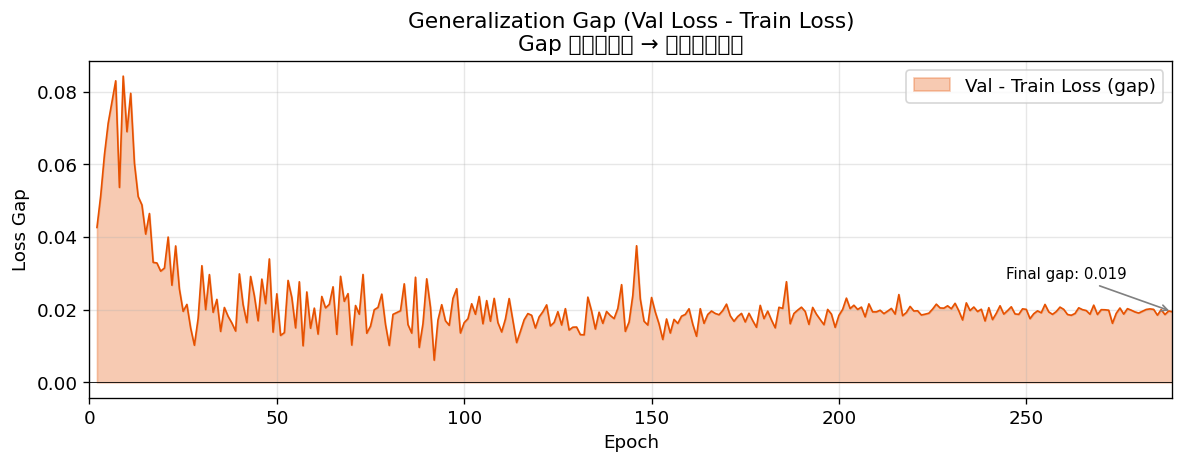

Train Loss (final): 0.0610
Val Loss (final):   0.0804
Gap:                0.0194

结论: gap ≈ 0.02 且后期未扩大 → 模型泛化良好，无明显过拟合


In [8]:
# ===== Train vs Val gap 分析 (过拟合检查) =====

fig, ax = plt.subplots(figsize=(10, 4))
gap = df_hist["val/loss"] - df_hist["train/loss"]
ax.fill_between(epochs, 0, gap, alpha=0.3, color="#E65100", label="Val - Train Loss (gap)")
ax.plot(epochs, gap, color="#E65100", lw=1)
ax.axhline(0, color="black", lw=0.5)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss Gap")
ax.set_title("Generalization Gap (Val Loss - Train Loss)\n"
             "Gap 稳定且较小 → 无严重过拟合")
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim(0, epochs.max())

# 标注最终 gap
final_gap = gap.iloc[-1]
ax.annotate(f"Final gap: {final_gap:.3f}",
            xy=(epochs.iloc[-1], final_gap), fontsize=9,
            xytext=(-100, 20), textcoords="offset points",
            arrowprops=dict(arrowstyle="->", color="gray"))

plt.tight_layout()
plt.show()

print(f"Train Loss (final): {df_hist['train/loss'].iloc[-1]:.4f}")
print(f"Val Loss (final):   {df_hist['val/loss'].iloc[-1]:.4f}")
print(f"Gap:                {final_gap:.4f}")
print(f"\n结论: gap ≈ 0.02 且后期未扩大 → 模型泛化良好，无明显过拟合")

<a id='5'></a>
## 5. 评估结果深度分析 Evaluation Deep Dive

In [9]:
# 加载评估结果
df_results = pd.read_csv(REPORTS / "results.csv")

# 分离 per-case 和 summary 行
df_cases = df_results[df_results["case_id"] != "MEAN"].copy()
df_mean  = df_results[df_results["case_id"] == "MEAN"].copy()

n_cases = df_cases["case_id"].nunique()
print(f"验证集: {n_cases} 个病例, 每个病例 3 个区域 (WT/TC/ET)")
print(f"总评估行数: {len(df_cases)}")
print(f"\n=== 平均指标 (Summary) ===")
display(df_mean.set_index("region")[["dice", "iou", "hd95", "sensitivity"]].round(4))

验证集: 147 个病例, 每个病例 3 个区域 (WT/TC/ET)
总评估行数: 441

=== 平均指标 (Summary) ===


dice     iou    hd95  sensitivity
region                                     
WT      0.9250  0.8674  6.7980       0.9212
TC      0.9213  0.8667  5.3117       0.9347
ET      0.8913  0.8148  3.7305       0.9085
ALL     0.9126  0.8496  5.2801       0.9215

In [10]:
# ===== 综合汇总表 =====

summary_rows = []
for region in ["WT", "TC", "ET"]:
    rdf = df_cases[df_cases["region"] == region]
    for metric in ["dice", "iou", "hd95", "sensitivity"]:
        vals = rdf[metric].replace([np.inf, -np.inf], np.nan).dropna()
        summary_rows.append({
            "Region": region,
            "Metric": metric.upper(),
            "Mean": vals.mean(),
            "Std": vals.std(),
            "Median": vals.median(),
            "Q1 (25%)": vals.quantile(0.25),
            "Q3 (75%)": vals.quantile(0.75),
            "Min": vals.min(),
            "Max": vals.max(),
        })

df_summary = pd.DataFrame(summary_rows)
display(df_summary.round(4))

Region       Metric    Mean      Std  Median  Q1 (25%)  Q3 (75%)     Min  \
0      WT         DICE  0.9250   0.0711  0.9483    0.9081    0.9690  0.4962   
1      WT          IOU  0.8674   0.1058  0.9017    0.8317    0.9399  0.3300   
2      WT         HD95  6.7980  13.2225  1.4142    1.0000    5.2907  1.0000   
3      WT  SENSITIVITY  0.9212   0.0908  0.9573    0.9076    0.9778  0.4035   
4      TC         DICE  0.9213   0.0984  0.9592    0.9226    0.9768  0.3989   
5      TC          IOU  0.8667   0.1408  0.9216    0.8564    0.9547  0.2491   
6      TC         HD95  5.3117  13.0226  1.0000    1.0000    2.2361  1.0000   
7      TC  SENSITIVITY  0.9347   0.0935  0.9668    0.9357    0.9824  0.4053   
8      ET         DICE  0.8913   0.0937  0.9247    0.8666    0.9483  0.3968   
9      ET          IOU  0.8148   0.1296  0.8599    0.7647    0.9017  0.2475   
10     ET         HD95  3.7305  10.7725  1.0000    1.0000    1.4142  1.0000   
11     ET  SENSITIVITY  0.9085   0.1006  0.9372    0.8989    0.9629  0.2801   

        Max  
0    0.9860  
1    0.9723  
2   74.6391  
3    0.9960  
4    0.9914  
5    0.9830  
6   91.8493  
7    0.9974  
8    0.9818  
9    0.9643  
10  90.7293  
11   0.9939

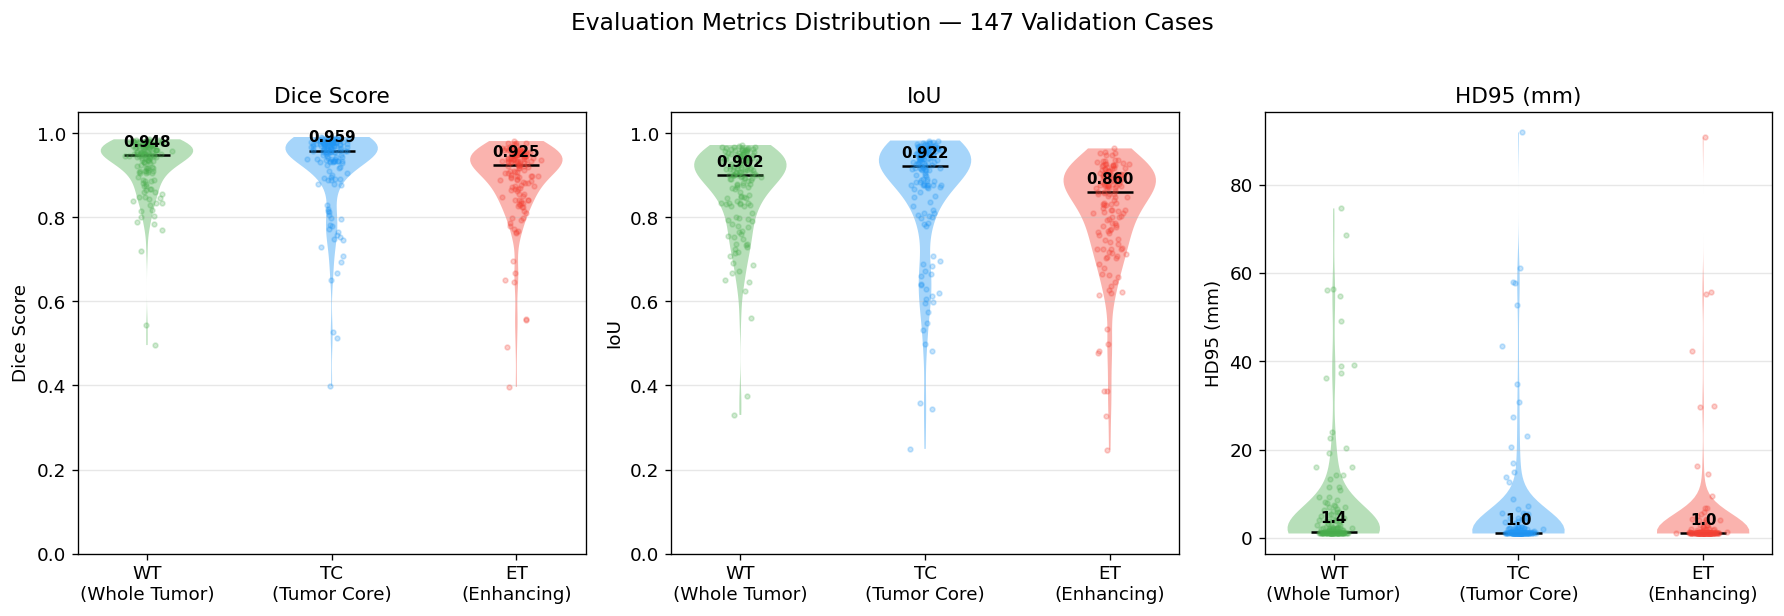

In [11]:
# ===== 图2: Dice Score 分布 (Violin + Strip) =====

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_info = [
    ("dice", "Dice Score", (0, 1.05)),
    ("iou", "IoU", (0, 1.05)),
    ("hd95", "HD95 (mm)", None),
]

for ax, (metric, label, ylim) in zip(axes, metrics_info):
    plot_data = []
    for region in ["WT", "TC", "ET"]:
        vals = df_cases[df_cases["region"] == region][metric]
        vals = vals.replace([np.inf, -np.inf], np.nan).dropna()
        plot_data.append(vals.values)

    parts = ax.violinplot(plot_data, positions=[1, 2, 3], showmedians=True, showextrema=False)
    for i, (pc, region) in enumerate(zip(parts["bodies"], ["WT", "TC", "ET"])):
        pc.set_facecolor(REGION_COLORS[region])
        pc.set_alpha(0.4)
    parts["cmedians"].set_color("black")

    # Overlay individual points
    for i, (region, vals) in enumerate(zip(["WT", "TC", "ET"], plot_data)):
        jitter = np.random.normal(0, 0.04, len(vals))
        ax.scatter(np.full_like(vals, i+1) + jitter, vals,
                   color=REGION_COLORS[region], alpha=0.25, s=8, zorder=3)
        ax.text(i+1, np.median(vals) + (0.02 if metric != "hd95" else 2),
                f"{np.median(vals):.3f}" if metric != "hd95" else f"{np.median(vals):.1f}",
                ha="center", fontsize=9, fontweight="bold")

    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(["WT\n(Whole Tumor)", "TC\n(Tumor Core)", "ET\n(Enhancing)"])
    ax.set_ylabel(label)
    ax.set_title(label)
    if ylim:
        ax.set_ylim(ylim)
    ax.grid(axis="y", alpha=0.3)

fig.suptitle(f"Evaluation Metrics Distribution — {n_cases} Validation Cases", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

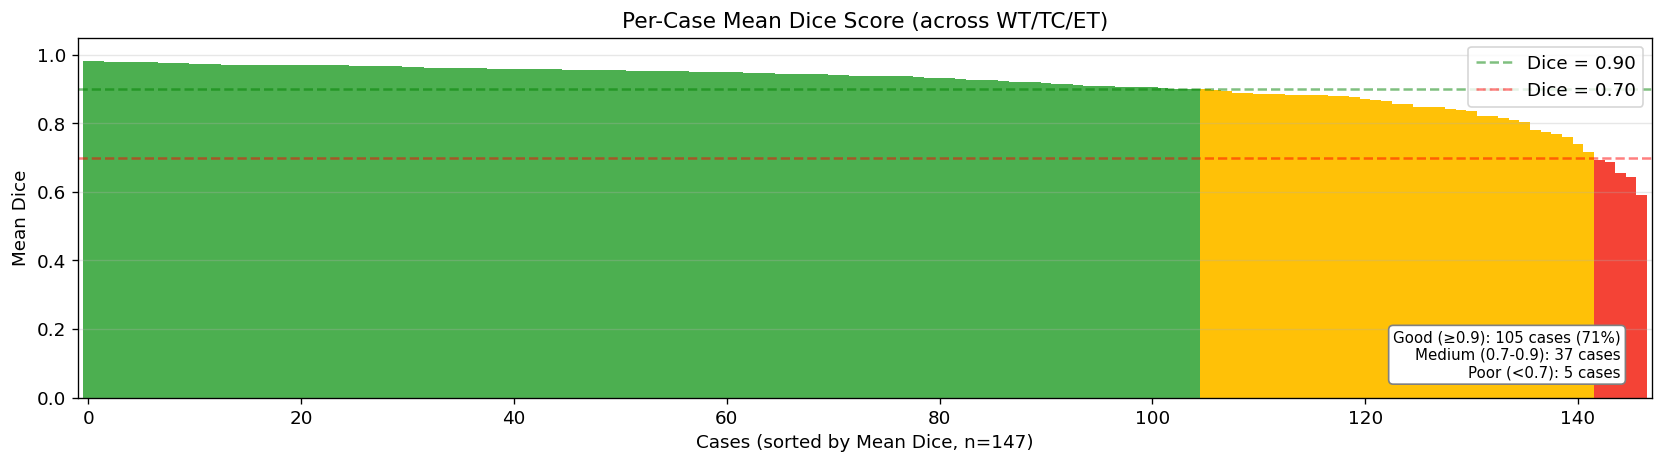

In [12]:
# ===== 图3: 每个病例的 Mean Dice 排序 =====

# 计算每个病例的 mean dice (across 3 regions)
case_mean_dice = df_cases.groupby("case_id")["dice"].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(14, 4))
colors = ["#4CAF50" if d >= 0.9 else "#FFC107" if d >= 0.7 else "#F44336" for d in case_mean_dice]
ax.bar(range(len(case_mean_dice)), case_mean_dice.values, color=colors, width=1.0, edgecolor="none")
ax.axhline(0.9, color="green", ls="--", alpha=0.5, label="Dice = 0.90")
ax.axhline(0.7, color="red", ls="--", alpha=0.5, label="Dice = 0.70")
ax.set_xlabel(f"Cases (sorted by Mean Dice, n={len(case_mean_dice)})")
ax.set_ylabel("Mean Dice")
ax.set_title("Per-Case Mean Dice Score (across WT/TC/ET)")
ax.set_xlim(-1, len(case_mean_dice))
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(axis="y", alpha=0.3)

# 统计
n_good = (case_mean_dice >= 0.9).sum()
n_ok   = ((case_mean_dice >= 0.7) & (case_mean_dice < 0.9)).sum()
n_bad  = (case_mean_dice < 0.7).sum()
ax.annotate(f"Good (≥0.9): {n_good} cases ({100*n_good/len(case_mean_dice):.0f}%)\n"
            f"Medium (0.7-0.9): {n_ok} cases\n"
            f"Poor (<0.7): {n_bad} cases",
            xy=(0.98, 0.05), xycoords="axes fraction", ha="right", va="bottom",
            fontsize=9, bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

plt.tight_layout()
plt.show()

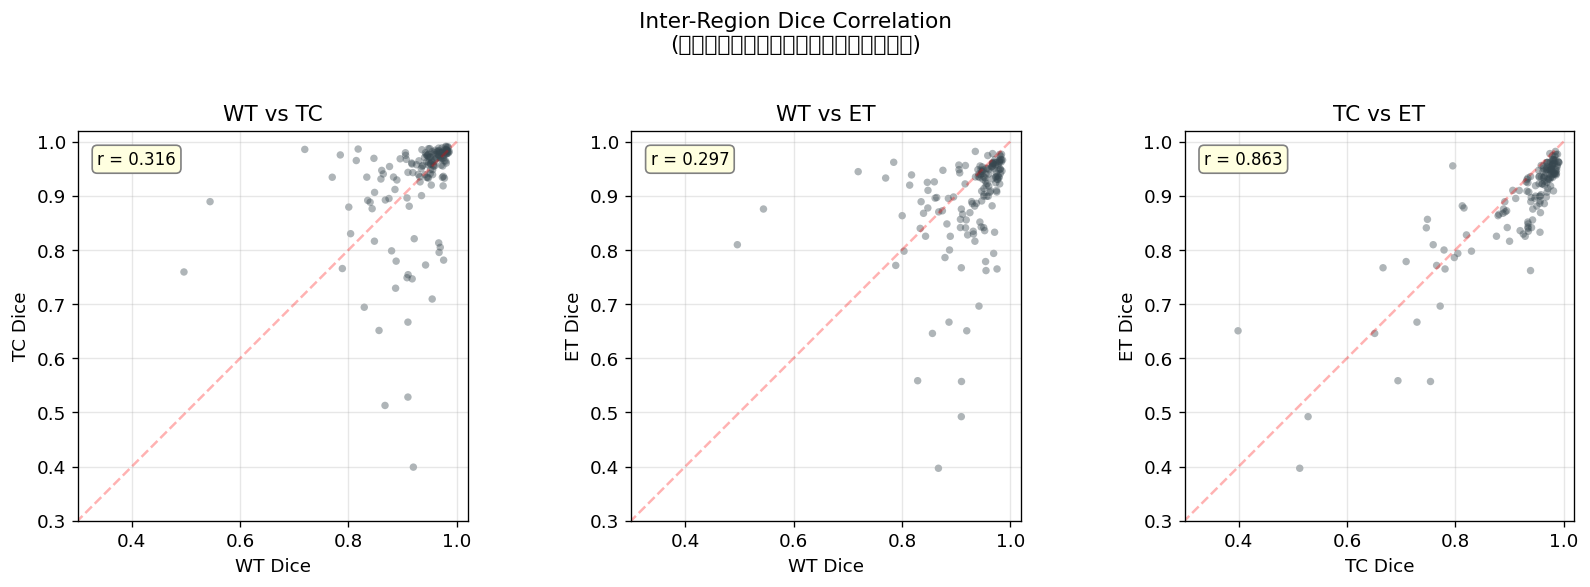

In [13]:
# ===== 图4: 三个区域的 Dice 相关性 =====

# Pivot: 每个 case 一行, WT/TC/ET 各一列
dice_pivot = df_cases.pivot(index="case_id", columns="region", values="dice")

fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))
pairs = [("WT", "TC"), ("WT", "ET"), ("TC", "ET")]

for ax, (r1, r2) in zip(axes, pairs):
    ax.scatter(dice_pivot[r1], dice_pivot[r2],
              alpha=0.4, s=20, color="#37474F", edgecolors="none")
    ax.plot([0, 1], [0, 1], "--", color="red", alpha=0.3, label="y=x")
    ax.set_xlabel(f"{r1} Dice")
    ax.set_ylabel(f"{r2} Dice")
    ax.set_title(f"{r1} vs {r2}")
    ax.set_xlim(0.3, 1.02)
    ax.set_ylim(0.3, 1.02)
    ax.set_aspect("equal")
    ax.grid(alpha=0.3)

    # 相关系数
    corr = dice_pivot[r1].corr(dice_pivot[r2])
    ax.annotate(f"r = {corr:.3f}", xy=(0.05, 0.95), xycoords="axes fraction",
                fontsize=10, va="top",
                bbox=dict(boxstyle="round", facecolor="lightyellow", edgecolor="gray"))

fig.suptitle("Inter-Region Dice Correlation\n"
             "(如果一个区域分割差，其他区域通常也差)", fontsize=13, y=1.05)
plt.tight_layout()
plt.show()

In [14]:
# ===== Top 10 最佳 / 最差病例 =====

print("🏆 Top 10 Best Cases (highest mean Dice):")
print("=" * 70)
for i, (case_id, dice) in enumerate(case_mean_dice.head(10).items(), 1):
    row = dice_pivot.loc[case_id]
    print(f"  {i:2d}. {case_id}  Mean={dice:.4f}  "
          f"WT={row['WT']:.4f}  TC={row['TC']:.4f}  ET={row['ET']:.4f}")

print(f"\n⚠️  Top 10 Worst Cases (lowest mean Dice):")
print("=" * 70)
for i, (case_id, dice) in enumerate(case_mean_dice.tail(10).items(), 1):
    row = dice_pivot.loc[case_id]
    # 找出哪个区域最差
    worst_region = row.idxmin()
    print(f"  {i:2d}. {case_id}  Mean={dice:.4f}  "
          f"WT={row['WT']:.4f}  TC={row['TC']:.4f}  ET={row['ET']:.4f}  "
          f"← worst: {worst_region}")

🏆 Top 10 Best Cases (highest mean Dice):
   1. BraTS2021_00816  Mean=0.9831  WT=0.9840  TC=0.9888  ET=0.9765
   2. BraTS2021_00426  Mean=0.9808  WT=0.9803  TC=0.9857  ET=0.9762
   3. BraTS2021_00663  Mean=0.9797  WT=0.9823  TC=0.9836  ET=0.9732
   4. BraTS2021_01018  Mean=0.9787  WT=0.9834  TC=0.9908  ET=0.9621
   5. BraTS2021_01021  Mean=0.9778  WT=0.9860  TC=0.9816  ET=0.9659
   6. BraTS2021_00235  Mean=0.9777  WT=0.9800  TC=0.9899  ET=0.9631
   7. BraTS2021_01134  Mean=0.9775  WT=0.9799  TC=0.9914  ET=0.9613
   8. BraTS2021_00780  Mean=0.9774  WT=0.9837  TC=0.9821  ET=0.9663
   9. BraTS2021_00814  Mean=0.9767  WT=0.9824  TC=0.9805  ET=0.9671
  10. BraTS2021_00187  Mean=0.9765  WT=0.9800  TC=0.9845  ET=0.9651

⚠️  Top 10 Worst Cases (lowest mean Dice):
   1. BraTS2021_00284  Mean=0.7752  WT=0.7887  TC=0.7655  ET=0.7713  ← worst: TC
   2. BraTS2021_01091  Mean=0.7696  WT=0.5444  TC=0.8891  ET=0.8755  ← worst: WT
   3. BraTS2021_00576  Mean=0.7609  WT=0.8870  TC=0.7292  ET=0.6666  ← wo

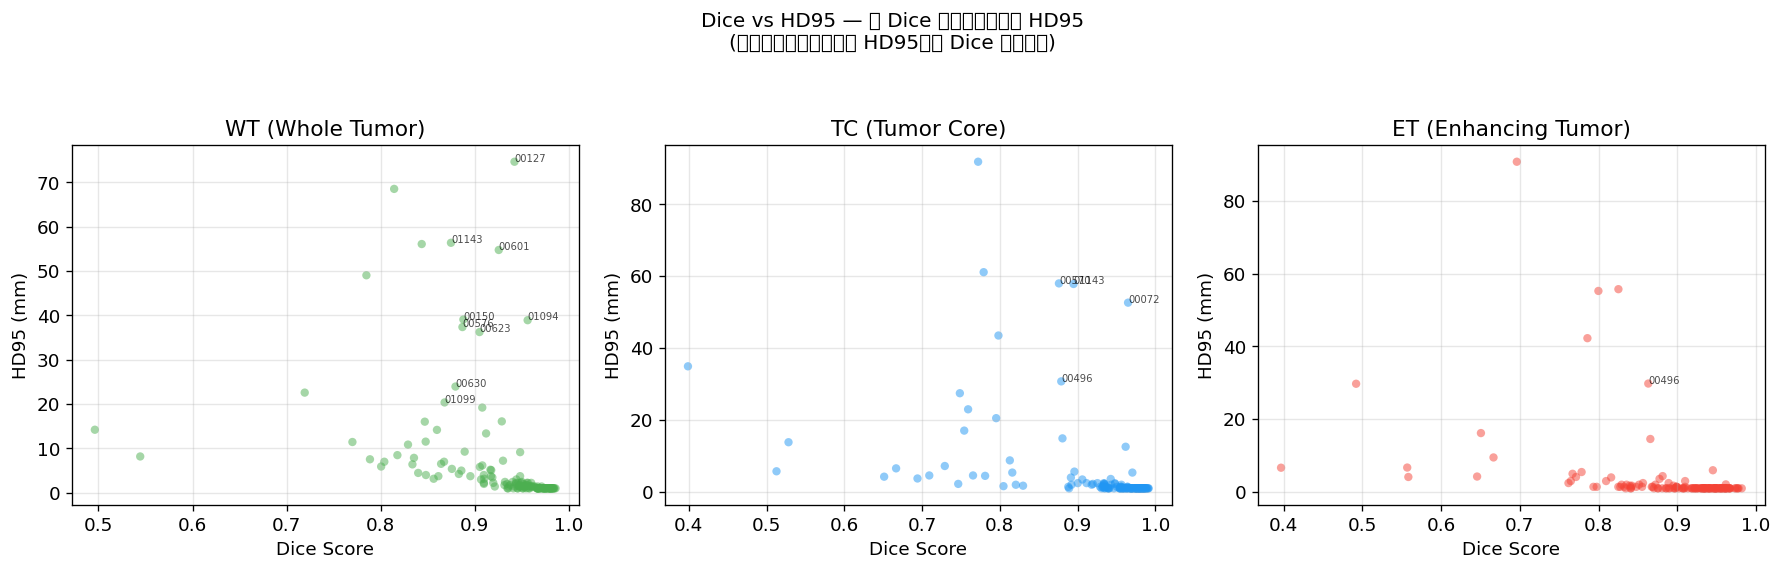

In [15]:
# ===== 图5: Dice vs HD95 关系 =====

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

for ax, region in zip(axes, ["WT", "TC", "ET"]):
    rdf = df_cases[df_cases["region"] == region].copy()
    rdf = rdf.replace([np.inf, -np.inf], np.nan).dropna(subset=["hd95"])

    scatter = ax.scatter(rdf["dice"], rdf["hd95"],
                        c=REGION_COLORS[region], alpha=0.5, s=25, edgecolors="none")
    ax.set_xlabel("Dice Score")
    ax.set_ylabel("HD95 (mm)")
    ax.set_title(f"{region} ({REGION_NAMES[region]})")
    ax.grid(alpha=0.3)

    # 标注: 高 Dice 但高 HD95 的异常点
    outliers = rdf[(rdf["dice"] > 0.85) & (rdf["hd95"] > 20)]
    for _, row in outliers.iterrows():
        ax.annotate(row["case_id"].replace("BraTS2021_", ""),
                    xy=(row["dice"], row["hd95"]),
                    fontsize=6, alpha=0.7)

fig.suptitle("Dice vs HD95 — 高 Dice 不一定意味着低 HD95\n"
             "(少量远处假阳性会推高 HD95，但 Dice 变化不大)",
             fontsize=12, y=1.05)
plt.tight_layout()
plt.show()

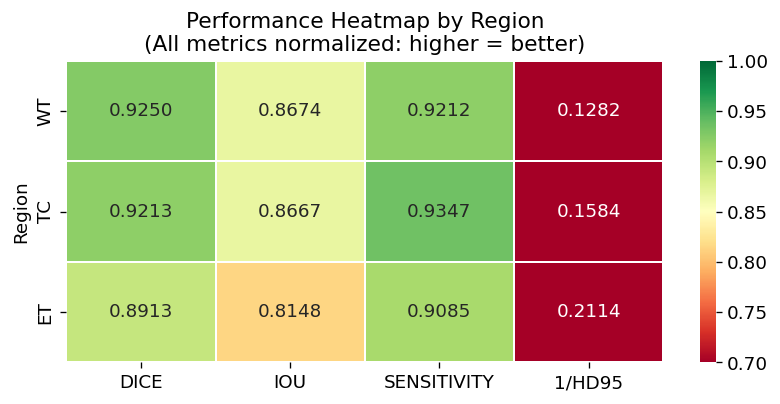

In [16]:
# ===== 图6: 指标热力图 (每个区域 x 每个指标) =====

heatmap_data = []
for region in ["WT", "TC", "ET"]:
    rdf = df_cases[df_cases["region"] == region]
    row = {"Region": region}
    for metric in ["dice", "iou", "sensitivity"]:
        row[metric.upper()] = rdf[metric].mean()
    # HD95: 反转使得大=差
    hd95_vals = rdf["hd95"].replace([np.inf], np.nan).dropna()
    row["1/HD95"] = 1.0 / (1.0 + hd95_vals.mean())  # 归一化到 0-1
    heatmap_data.append(row)

df_heat = pd.DataFrame(heatmap_data).set_index("Region")

fig, ax = plt.subplots(figsize=(7, 3.5))
sns.heatmap(df_heat, annot=True, fmt=".4f", cmap="RdYlGn",
            vmin=0.7, vmax=1.0, linewidths=1, linecolor="white", ax=ax)
ax.set_title("Performance Heatmap by Region\n(All metrics normalized: higher = better)")
plt.tight_layout()
plt.show()

<a id='6'></a>
## 6. 预处理可视化 Preprocessing Visualization

> 以下图片来自 `notebooks/00_preprocessing_demo.ipynb` 的输出，展示三种预处理技术。

### 6.1 N4ITK Bias Field Correction (偏置场校正)


**问题**: MRI 磁场不均匀 → 同一组织在不同位置亮度不同  
**方法**: N4 算法用 B-spline 拟合低频偏置场，然后除以它  
**效果**: 校正后同一组织的亮度更均匀


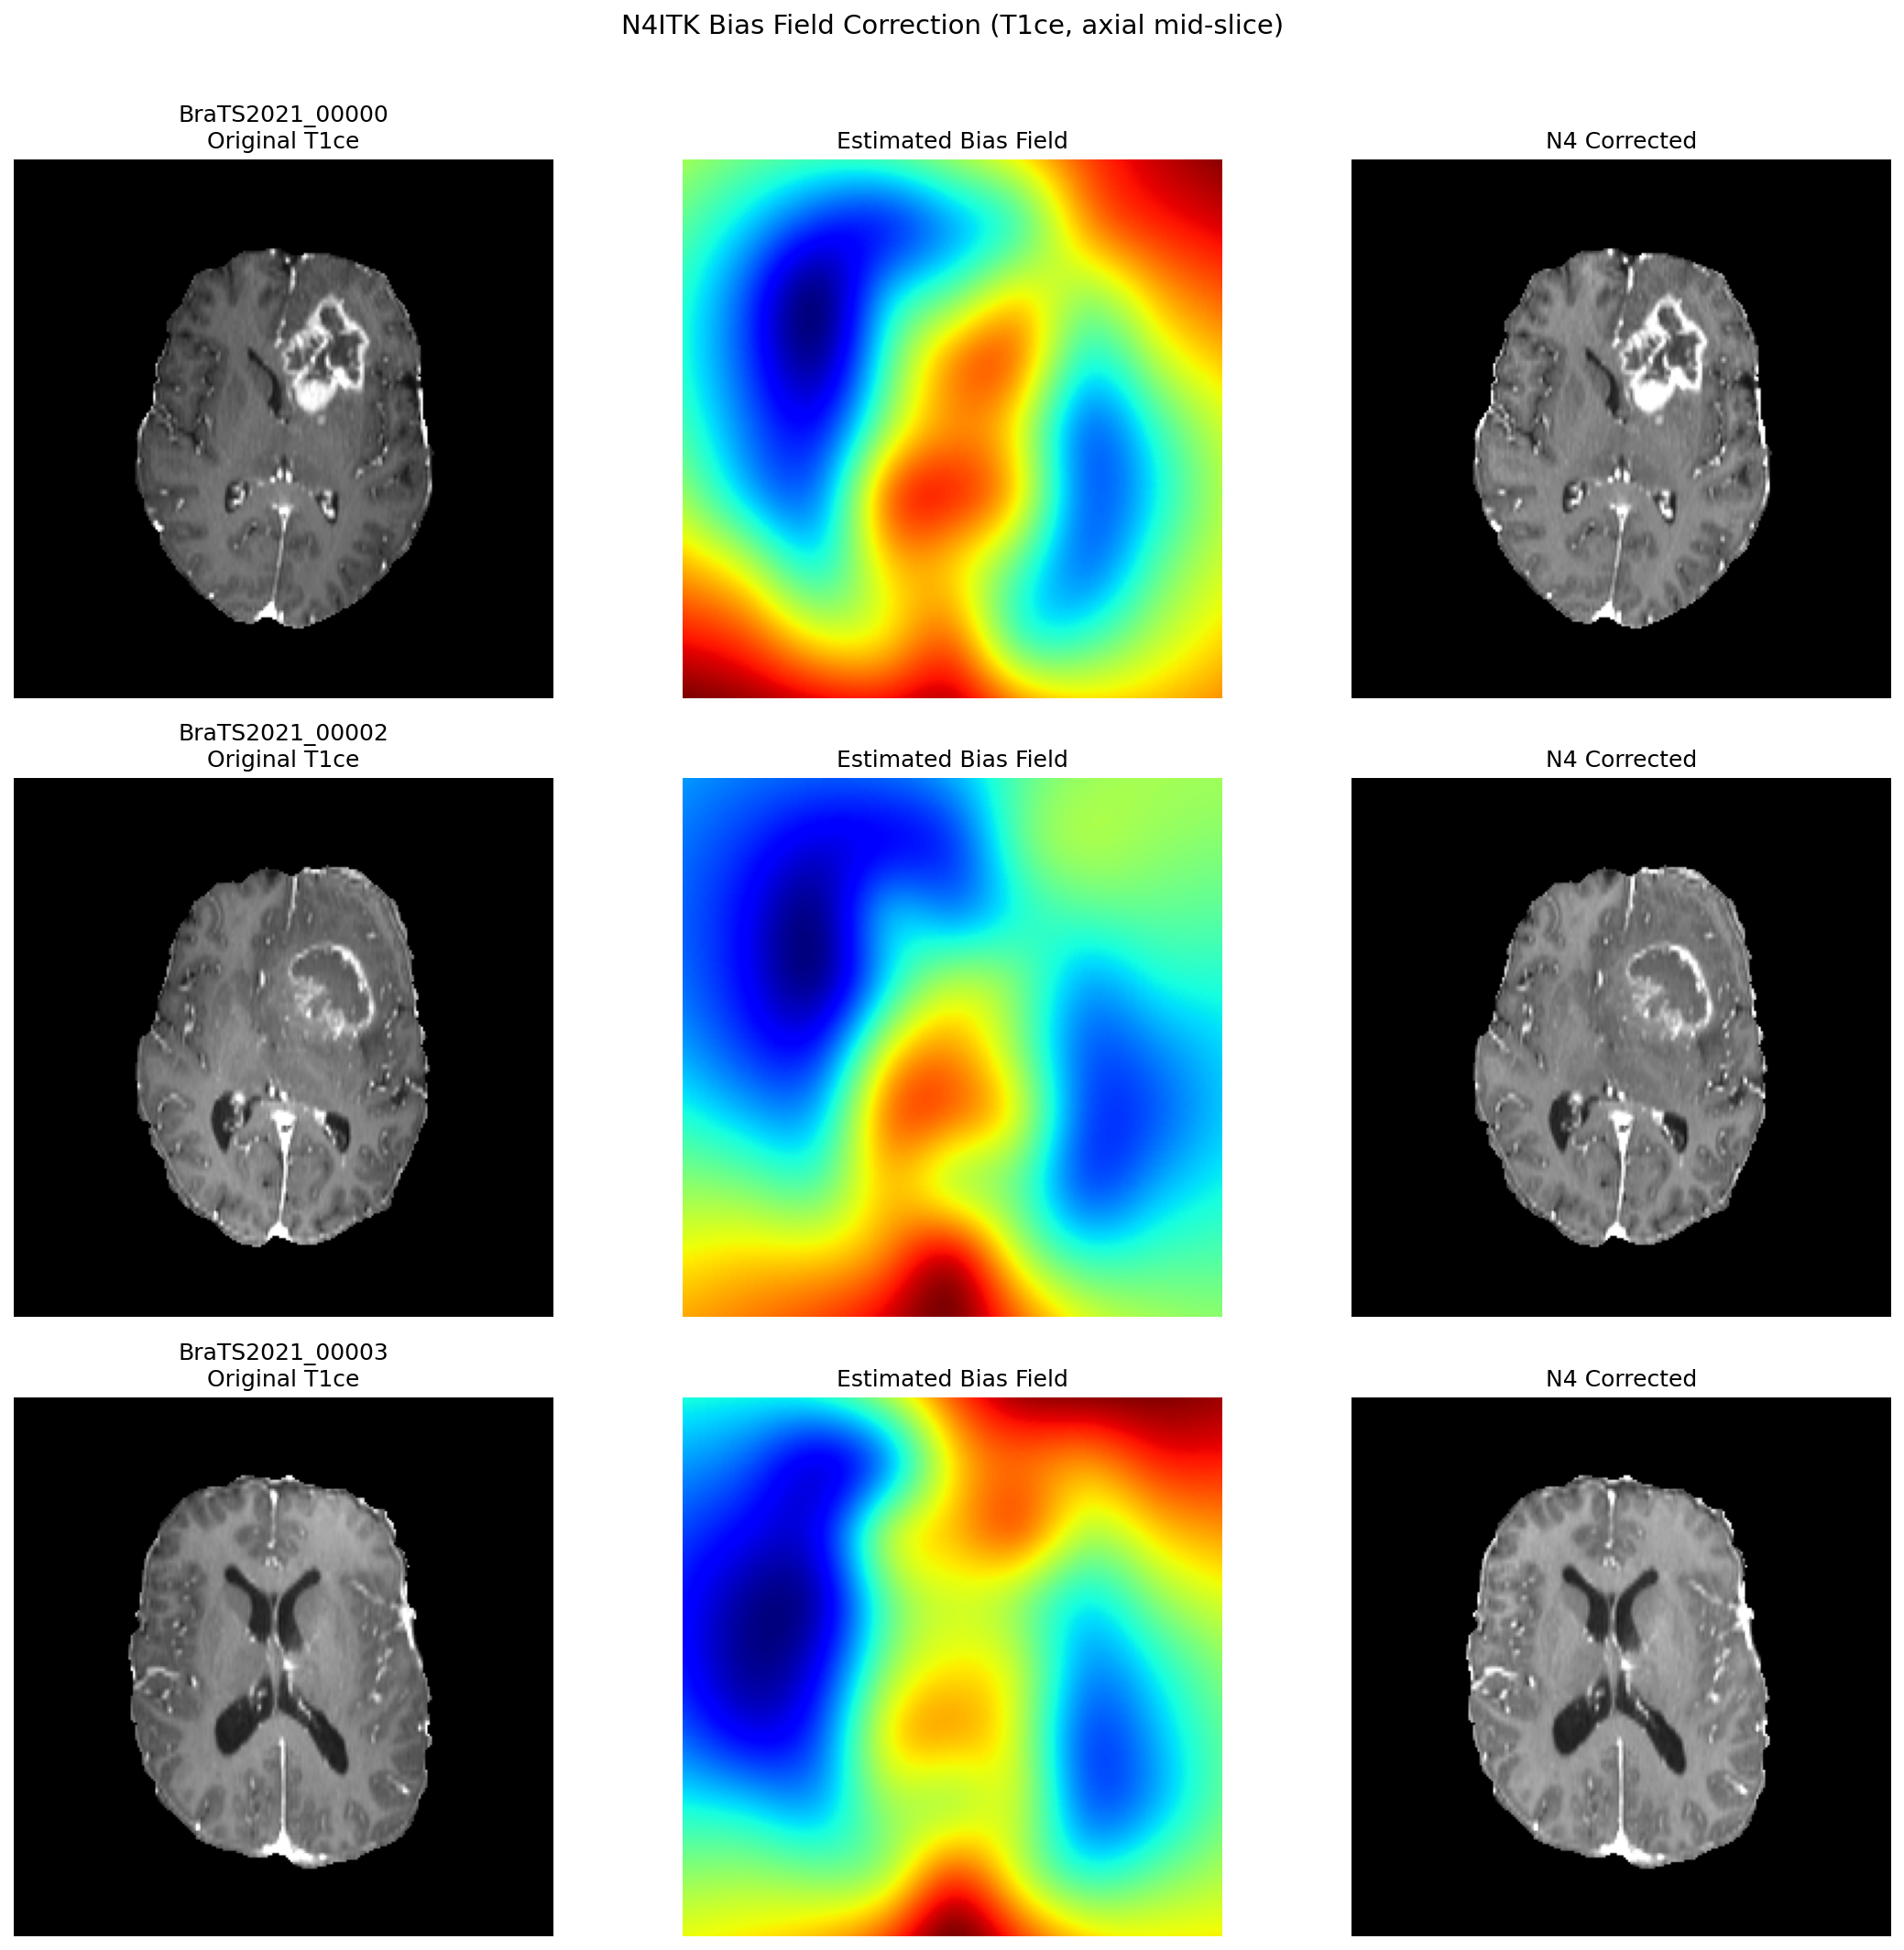

In [17]:
display(Markdown("### 6.1 N4ITK Bias Field Correction (偏置场校正)"))
display(Markdown("""
**问题**: MRI 磁场不均匀 → 同一组织在不同位置亮度不同  
**方法**: N4 算法用 B-spline 拟合低频偏置场，然后除以它  
**效果**: 校正后同一组织的亮度更均匀
"""))

img_path = OUTPUTS / "bias_field" / "bias_field_comparison.png"
if img_path.exists():
    display(Image(filename=str(img_path), width=700))
else:
    print(f"⚠️ Image not found: {img_path}")

### 6.2 Curvature Flow Denoising (曲率流去噪)


**问题**: MRI 热噪声降低图像质量  
**方法**: 各向异性扩散滤波 — 在平坦区域平滑噪声，在边缘处保持锐利  
**效果**: 右列差异图显示被去除的噪声分布


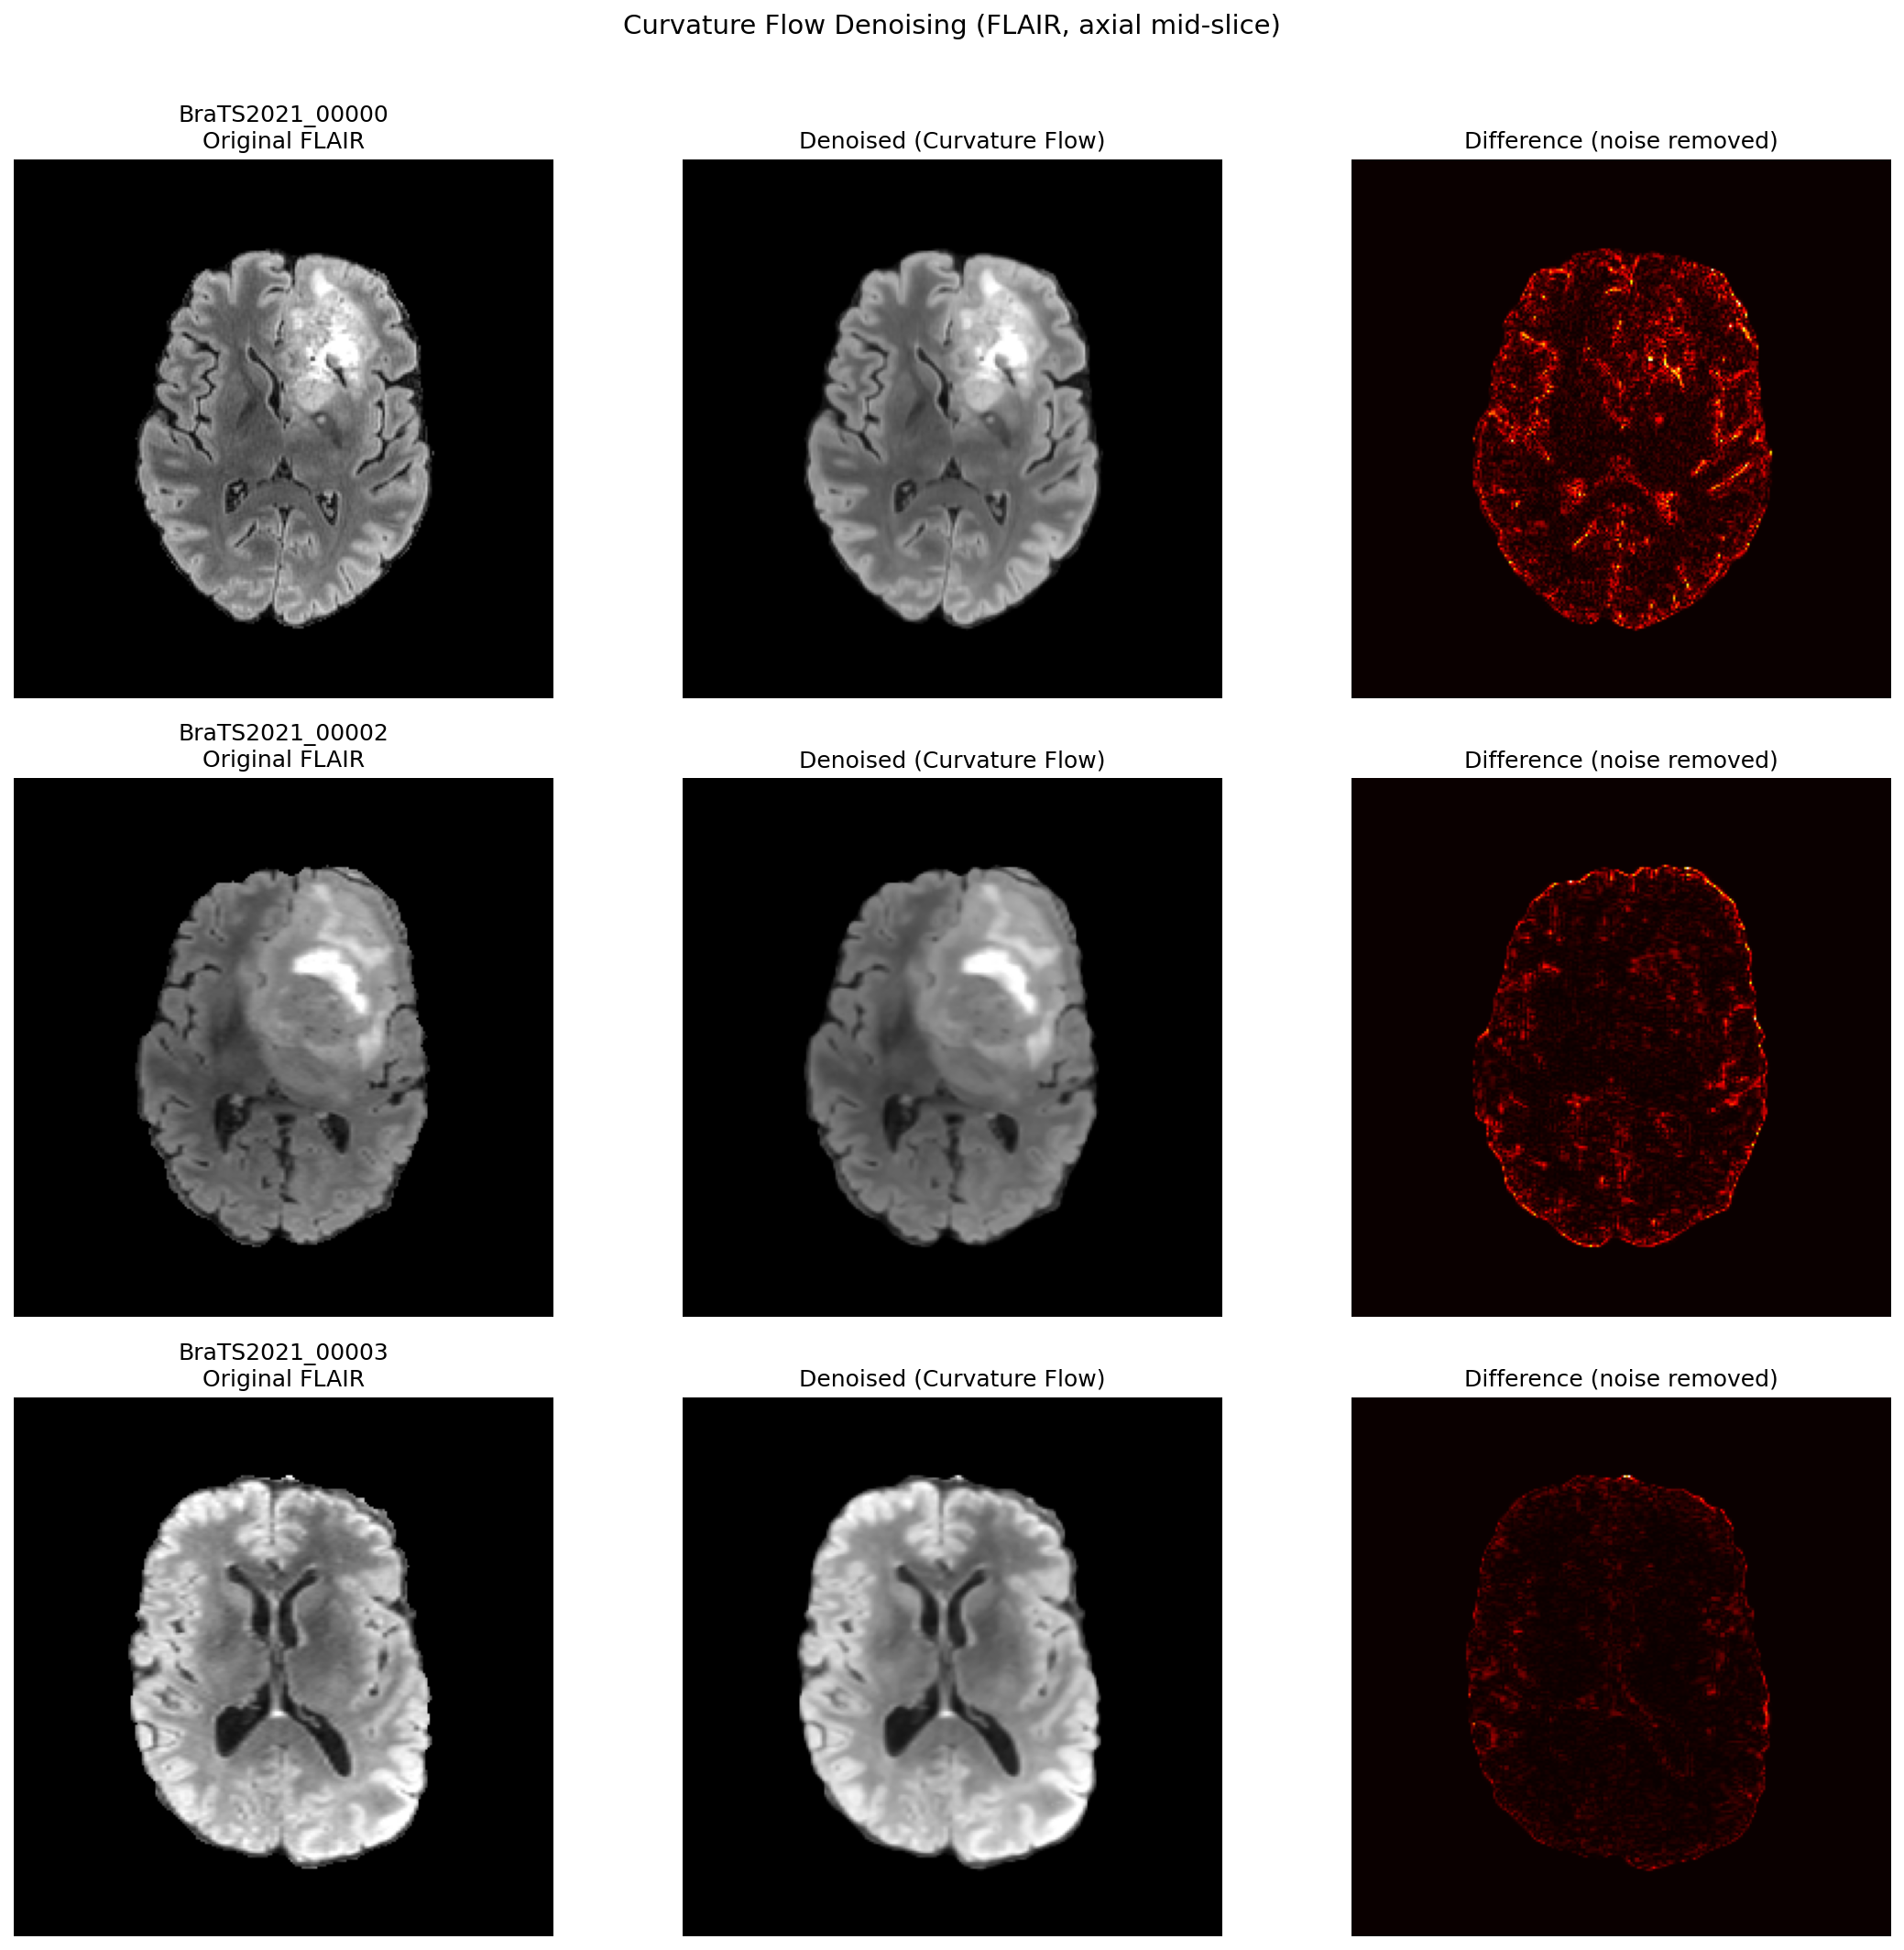

In [18]:
display(Markdown("### 6.2 Curvature Flow Denoising (曲率流去噪)"))
display(Markdown("""
**问题**: MRI 热噪声降低图像质量  
**方法**: 各向异性扩散滤波 — 在平坦区域平滑噪声，在边缘处保持锐利  
**效果**: 右列差异图显示被去除的噪声分布
"""))

img_path = OUTPUTS / "denoised" / "denoising_comparison.png"
if img_path.exists():
    display(Image(filename=str(img_path), width=700))
else:
    print(f"⚠️ Image not found: {img_path}")

### 6.3 Rigid Registration (刚体配准)


**问题**: 不同模态的扫描可能有微小的空间偏移  
**方法**: Euler3D 刚体变换 (平移+旋转) + Mattes 互信息 + 多分辨率优化  
**效果**: 棋盘格可视化显示配准前后的对齐改善


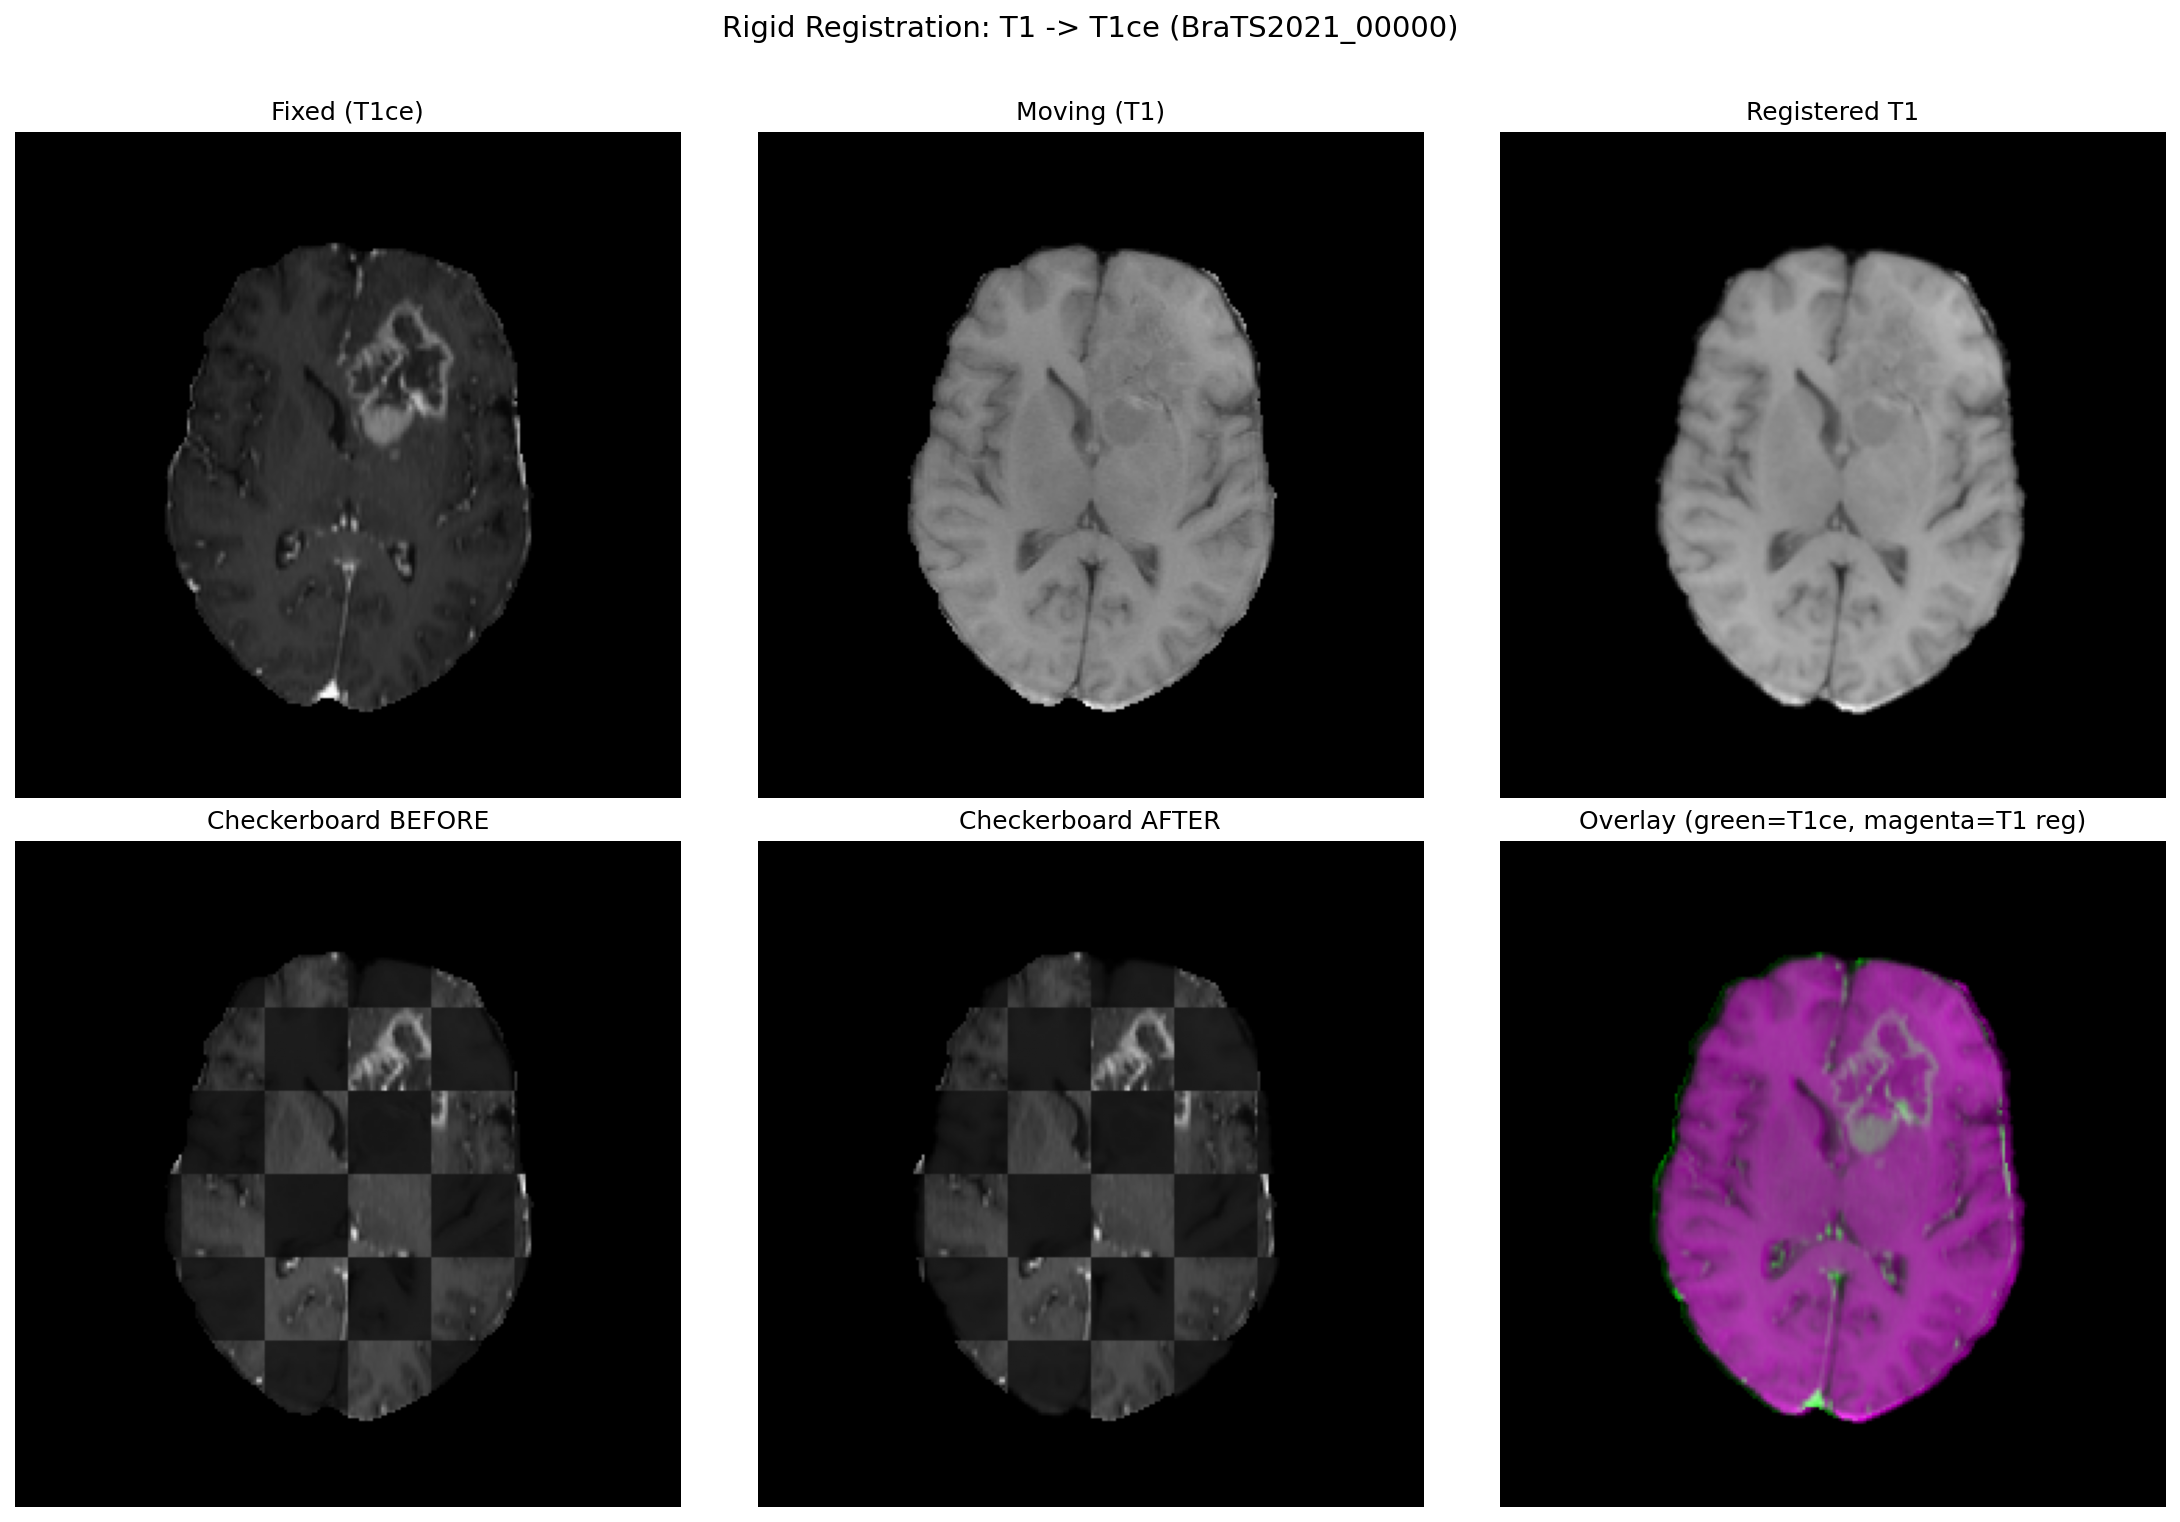

In [19]:
display(Markdown("### 6.3 Rigid Registration (刚体配准)"))
display(Markdown("""
**问题**: 不同模态的扫描可能有微小的空间偏移  
**方法**: Euler3D 刚体变换 (平移+旋转) + Mattes 互信息 + 多分辨率优化  
**效果**: 棋盘格可视化显示配准前后的对齐改善
"""))

img_path = OUTPUTS / "registration" / "registration_demo.png"
if img_path.exists():
    display(Image(filename=str(img_path), width=700))
else:
    print(f"⚠️ Image not found: {img_path}")

<a id='7'></a>
## 7. 分割效果展示 Segmentation Results

> 以下图片由 `reports/generate_figures.py` 预生成。

### 7.1 分割对比: 4 个代表性病例


从左到右: **FLAIR 原图** → **Ground Truth** → **模型预测**  
4 行分别是: Best (Dice=0.983), 75th pct, Median, 25th pct

颜色: 🔵 NCR/NET (坏死核心, label=1) | 🟢 ED (水肿, label=2) | 🔴 ET (增强肿瘤, label=4)


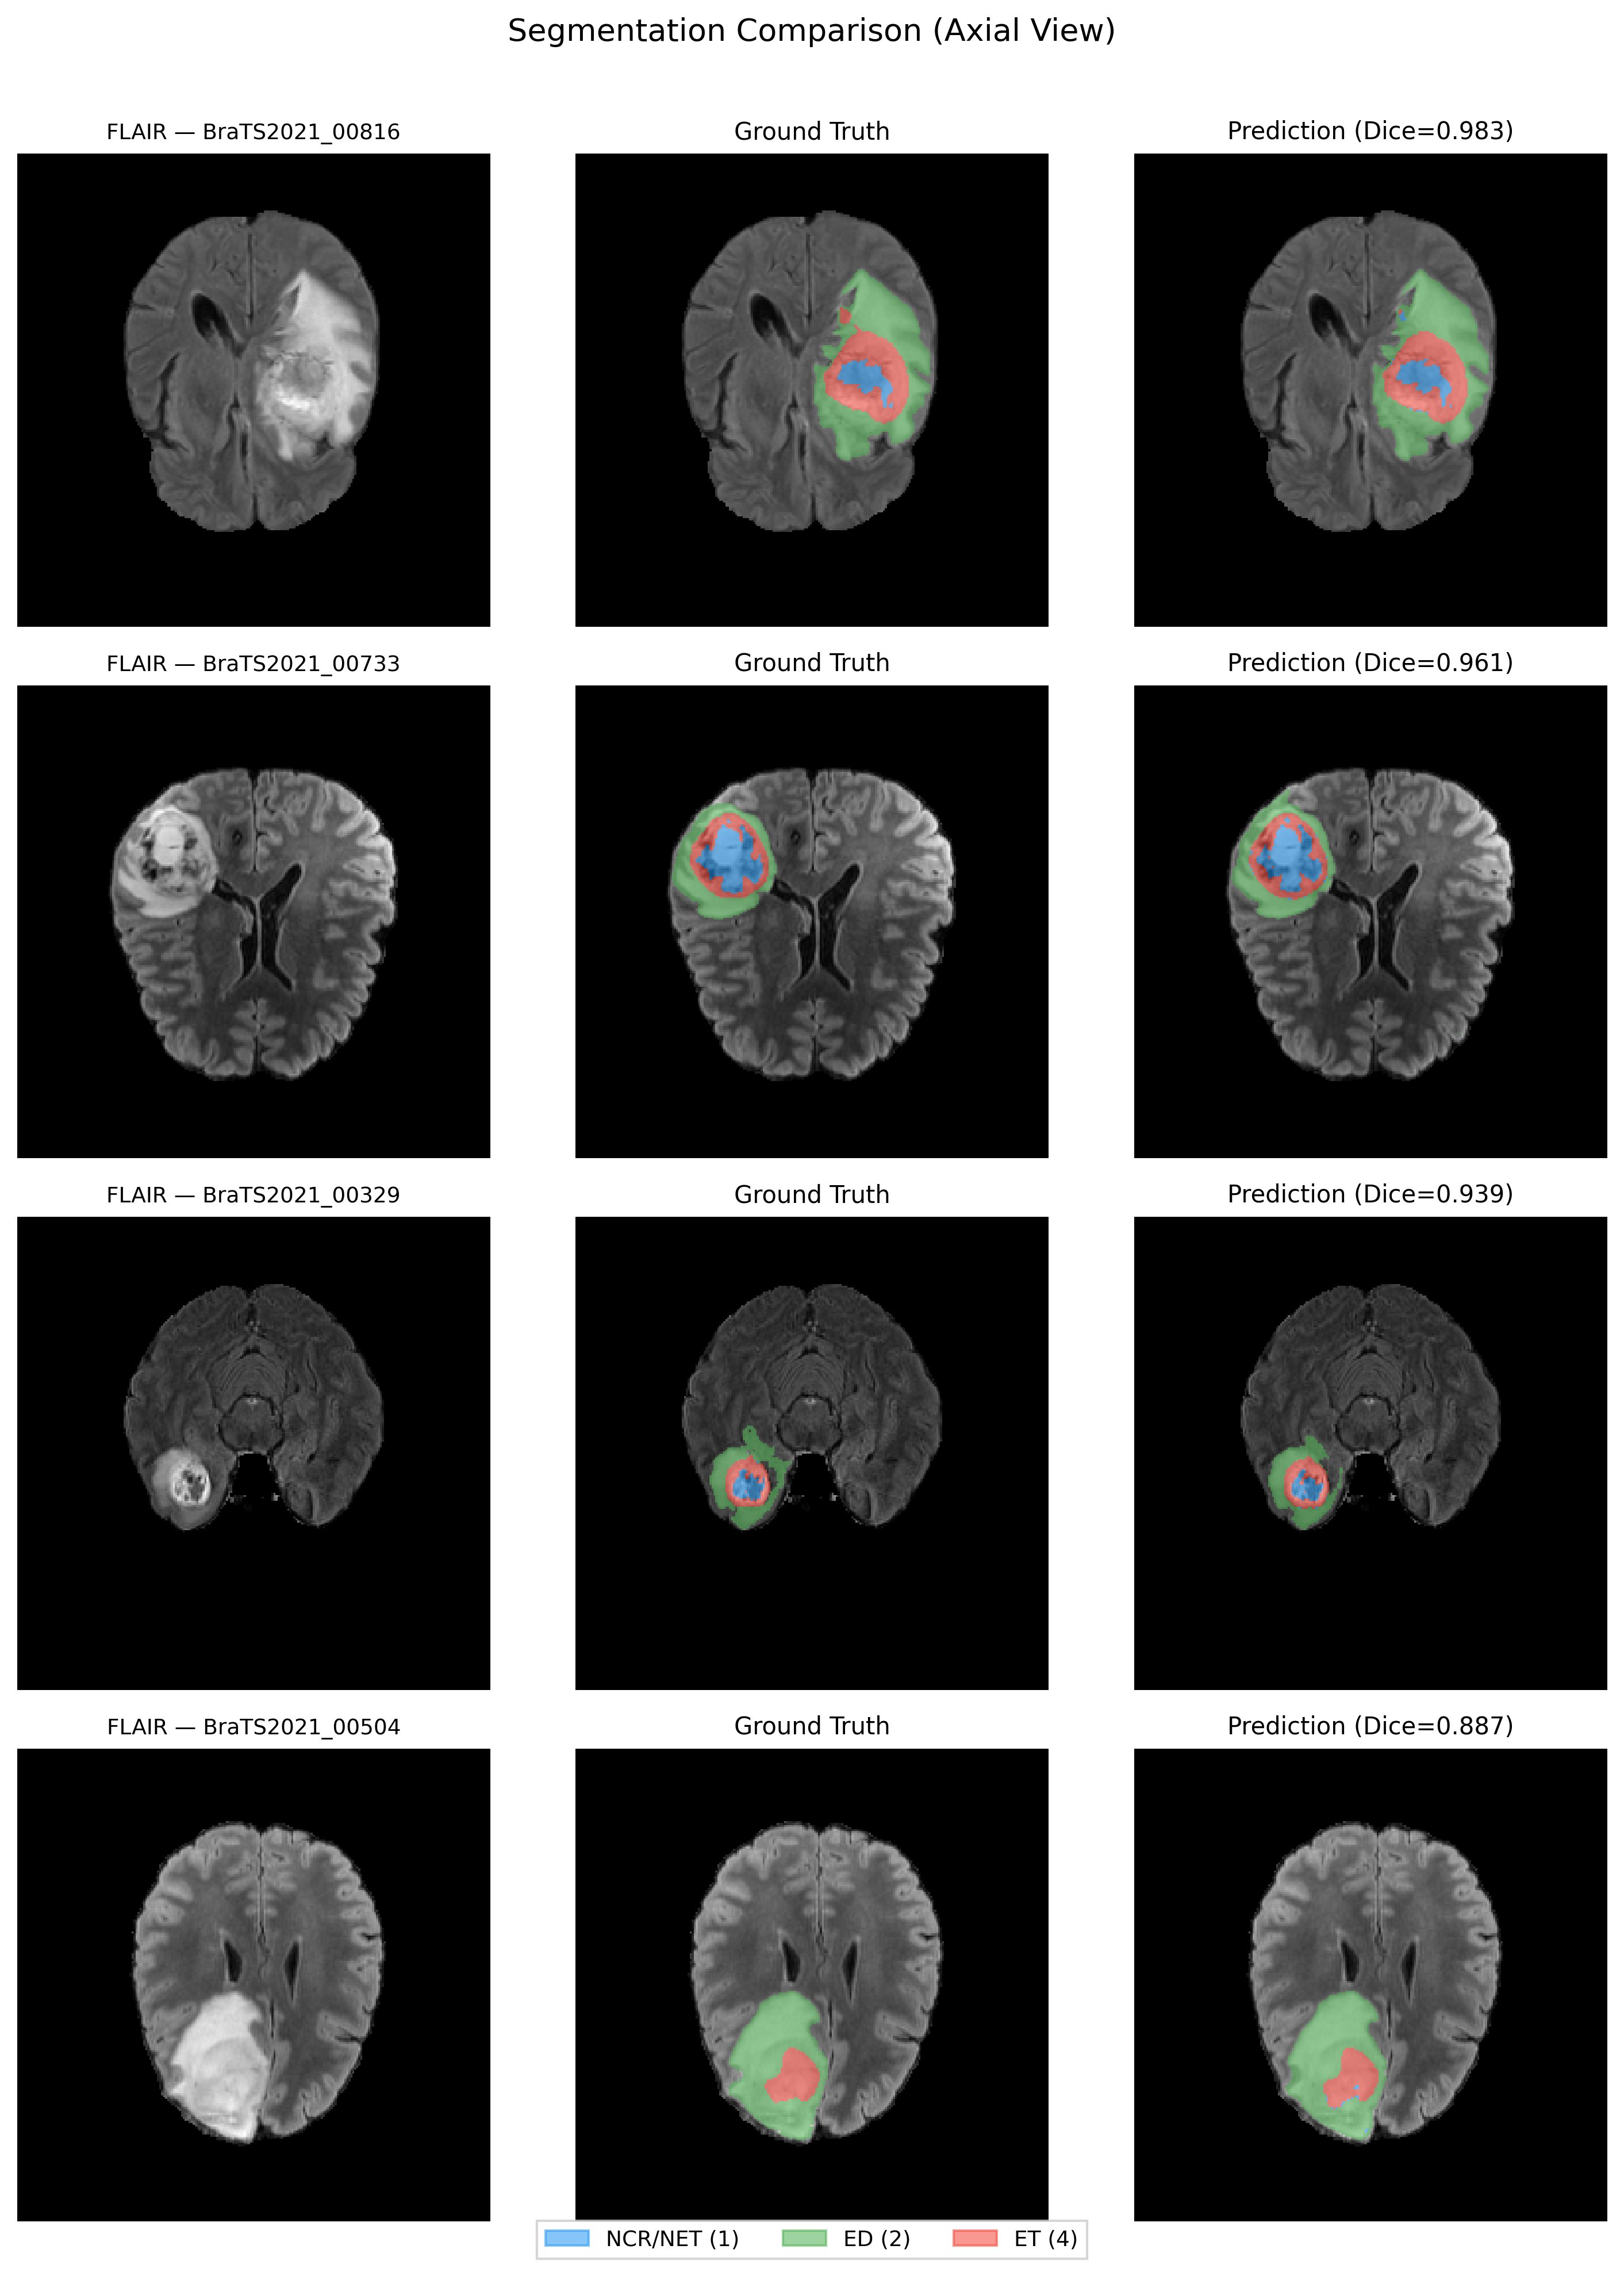

In [20]:
display(Markdown("### 7.1 分割对比: 4 个代表性病例"))
display(Markdown("""
从左到右: **FLAIR 原图** → **Ground Truth** → **模型预测**  
4 行分别是: Best (Dice=0.983), 75th pct, Median, 25th pct

颜色: 🔵 NCR/NET (坏死核心, label=1) | 🟢 ED (水肿, label=2) | 🔴 ET (增强肿瘤, label=4)
"""))

img_path = FIGURES / "segmentation_comparison.png"
if img_path.exists():
    display(Image(filename=str(img_path), width=650))
else:
    print(f"⚠️ Image not found: {img_path}")

### 7.2 最佳病例多视角展示


**BraTS2021_00816** (Mean Dice = 0.983)  
上排: Ground Truth | 下排: 模型预测  
三列: Axial (轴位) | Coronal (冠状) | Sagittal (矢状)


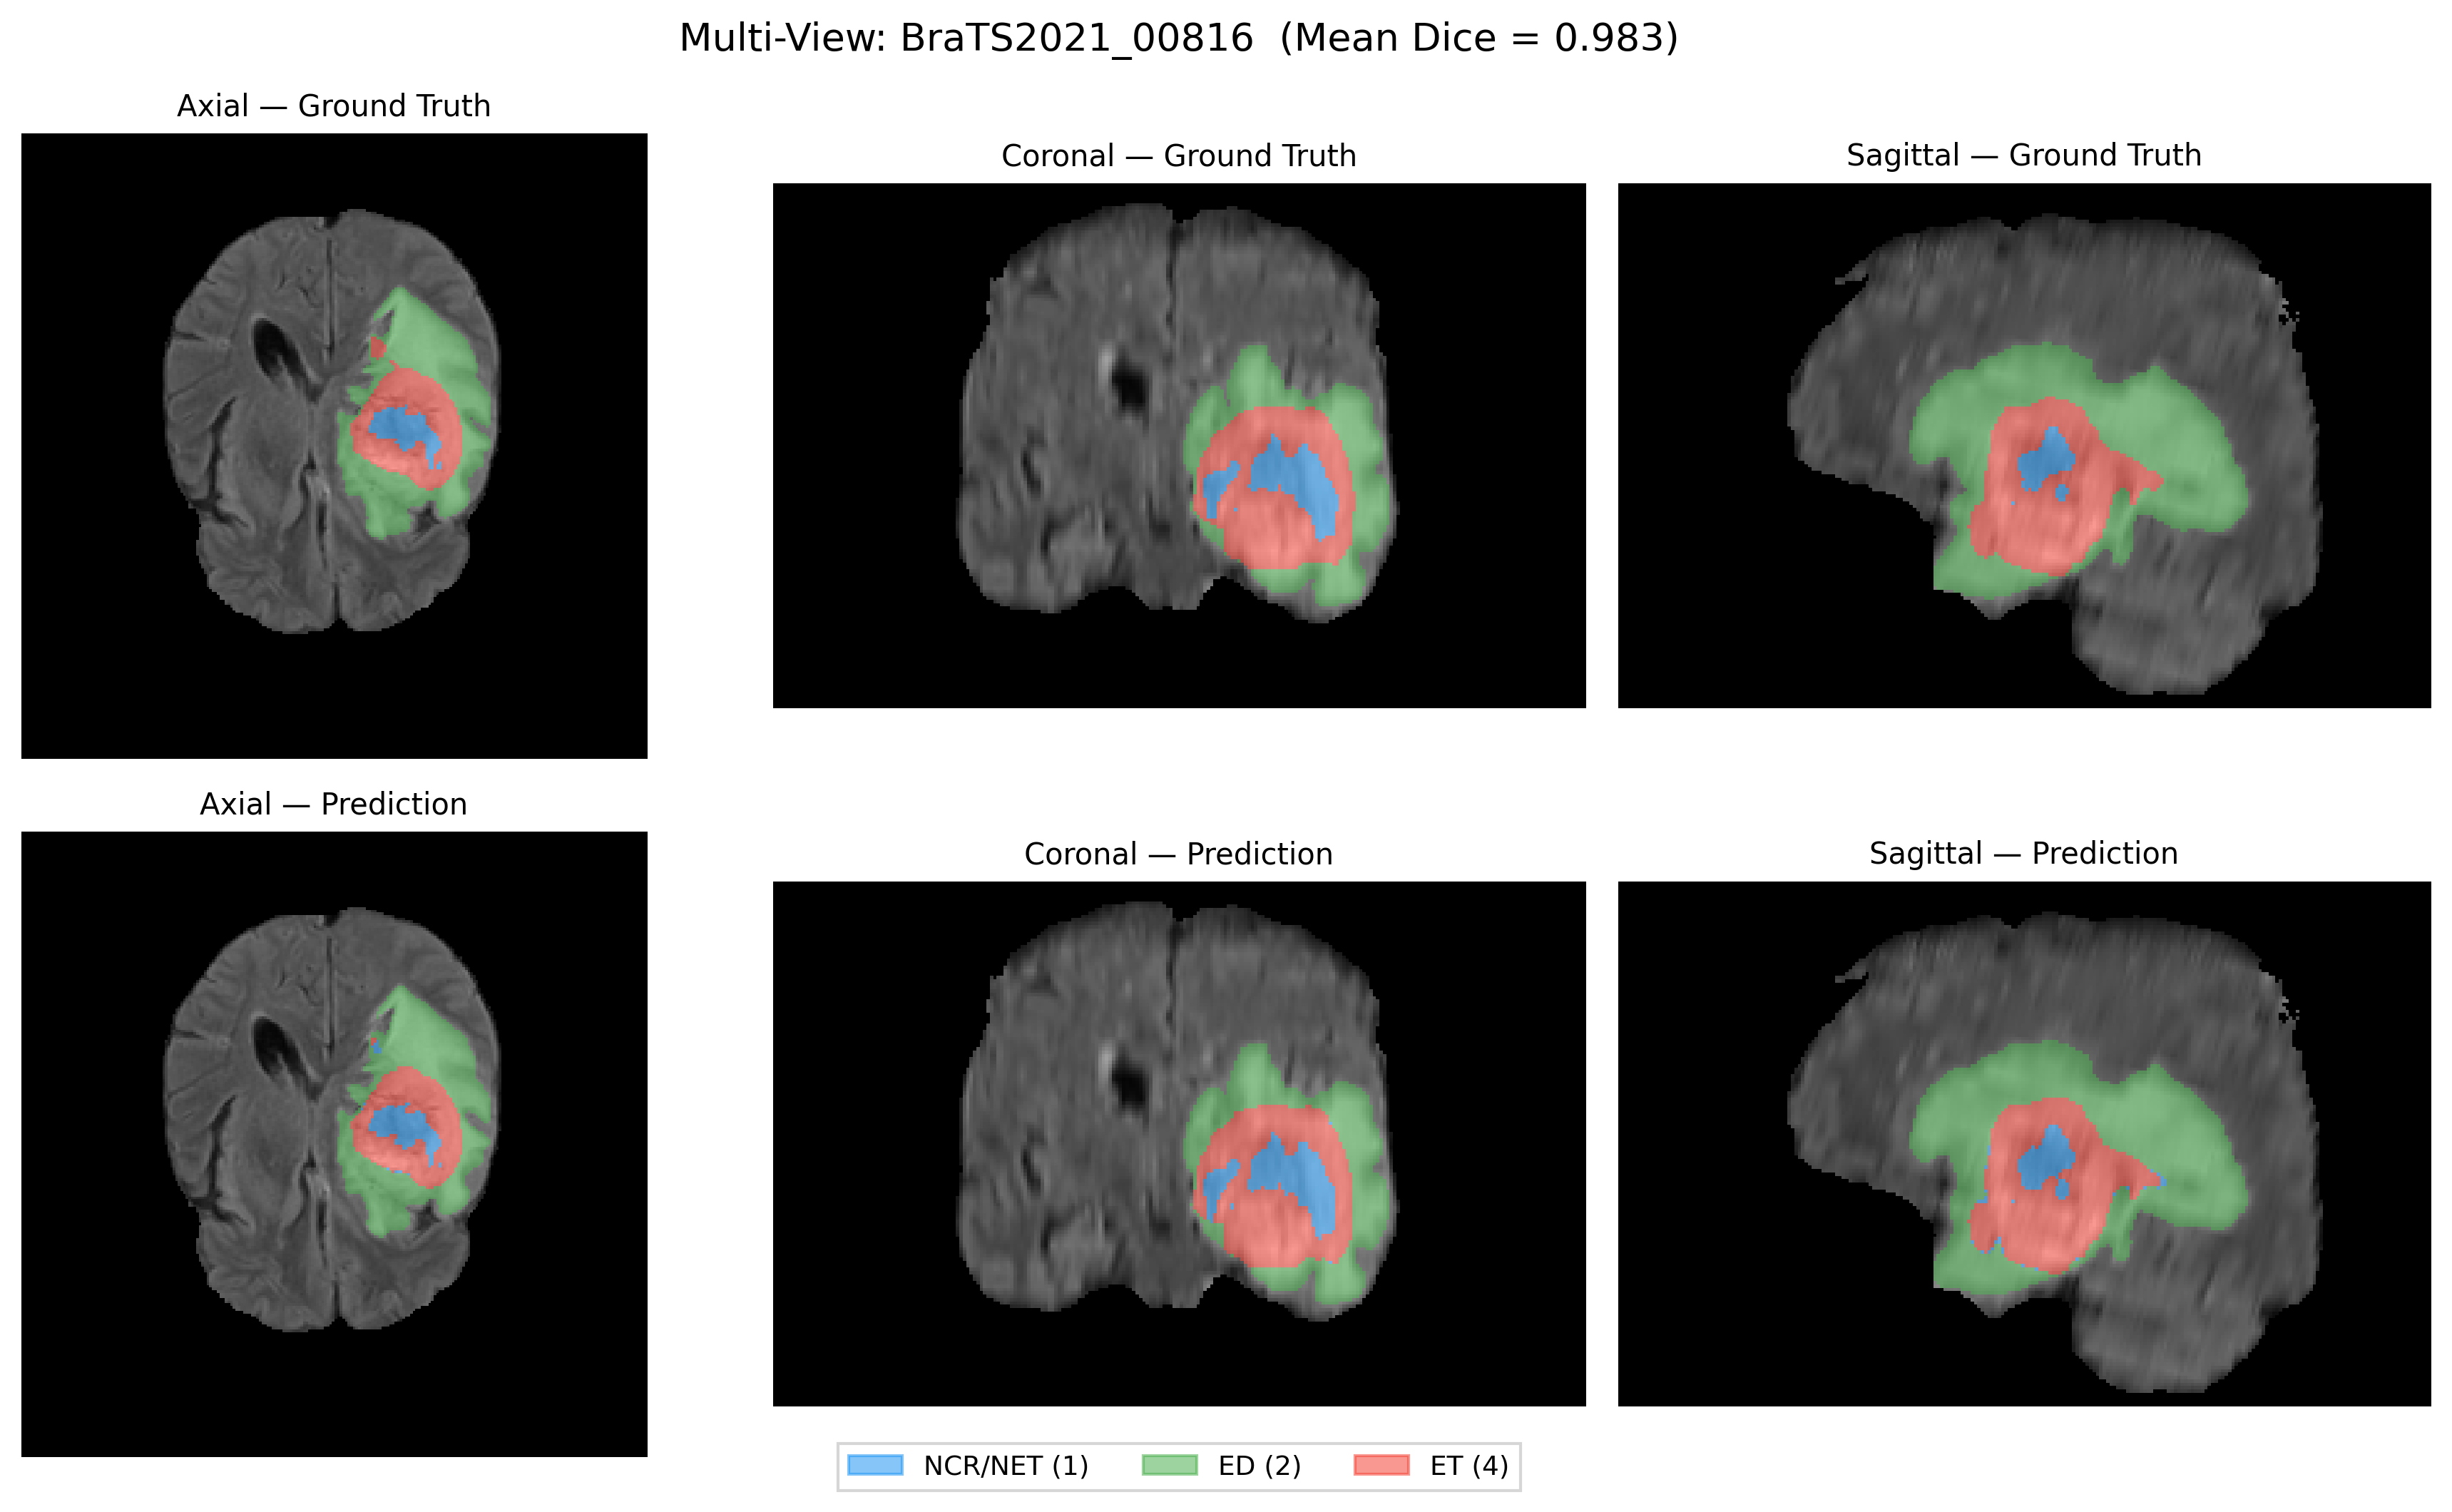

In [21]:
display(Markdown("### 7.2 最佳病例多视角展示"))
display(Markdown("""
**BraTS2021_00816** (Mean Dice = 0.983)  
上排: Ground Truth | 下排: 模型预测  
三列: Axial (轴位) | Coronal (冠状) | Sagittal (矢状)
"""))

img_path = FIGURES / "multi_view_prediction.png"
if img_path.exists():
    display(Image(filename=str(img_path), width=700))
else:
    print(f"⚠️ Image not found: {img_path}")

### 7.3 已生成的 Metrics Boxplot

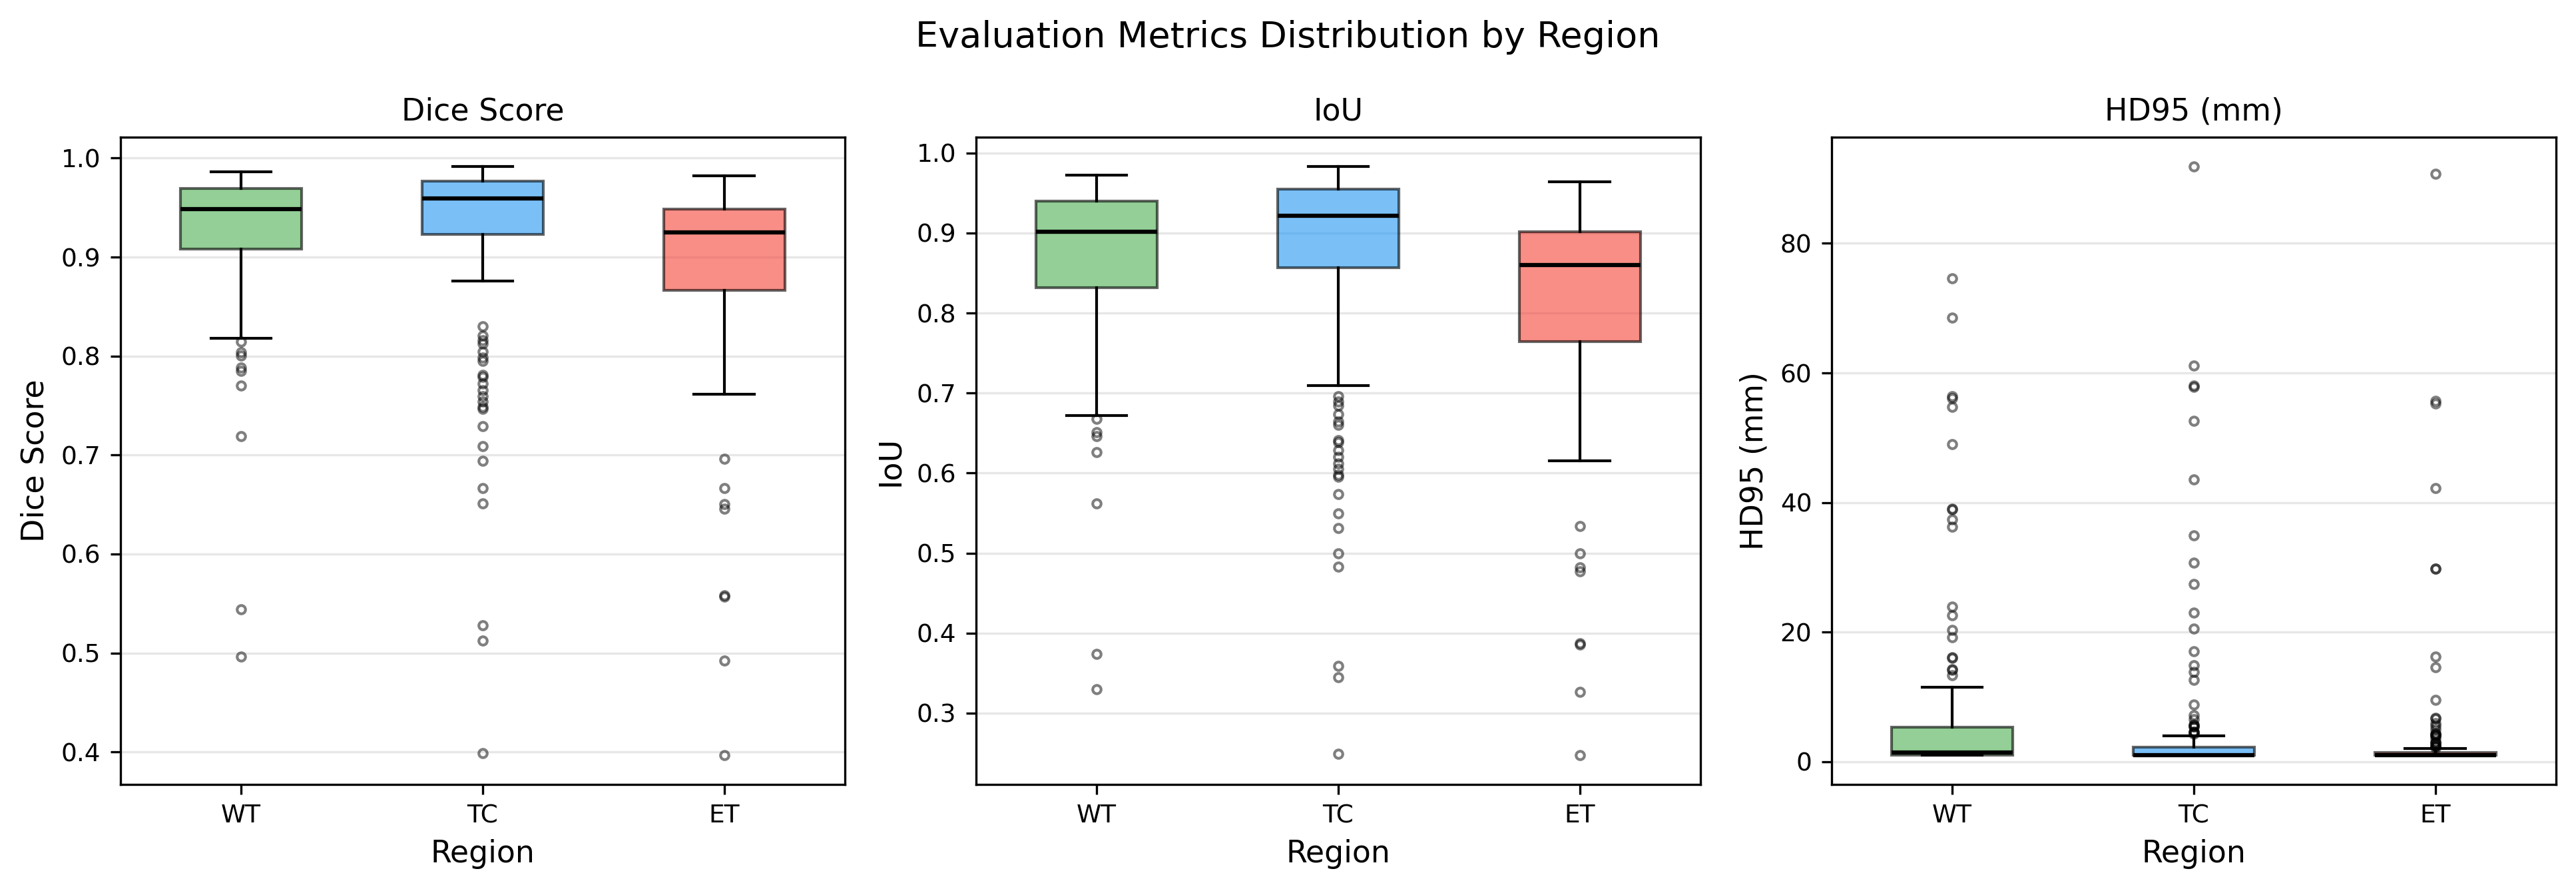

In [22]:
display(Markdown("### 7.3 已生成的 Metrics Boxplot"))

img_path = FIGURES / "metrics_boxplot.png"
if img_path.exists():
    display(Image(filename=str(img_path), width=800))
else:
    print(f"⚠️ Image not found: {img_path}")

### 7.4 已生成的 Training Curves

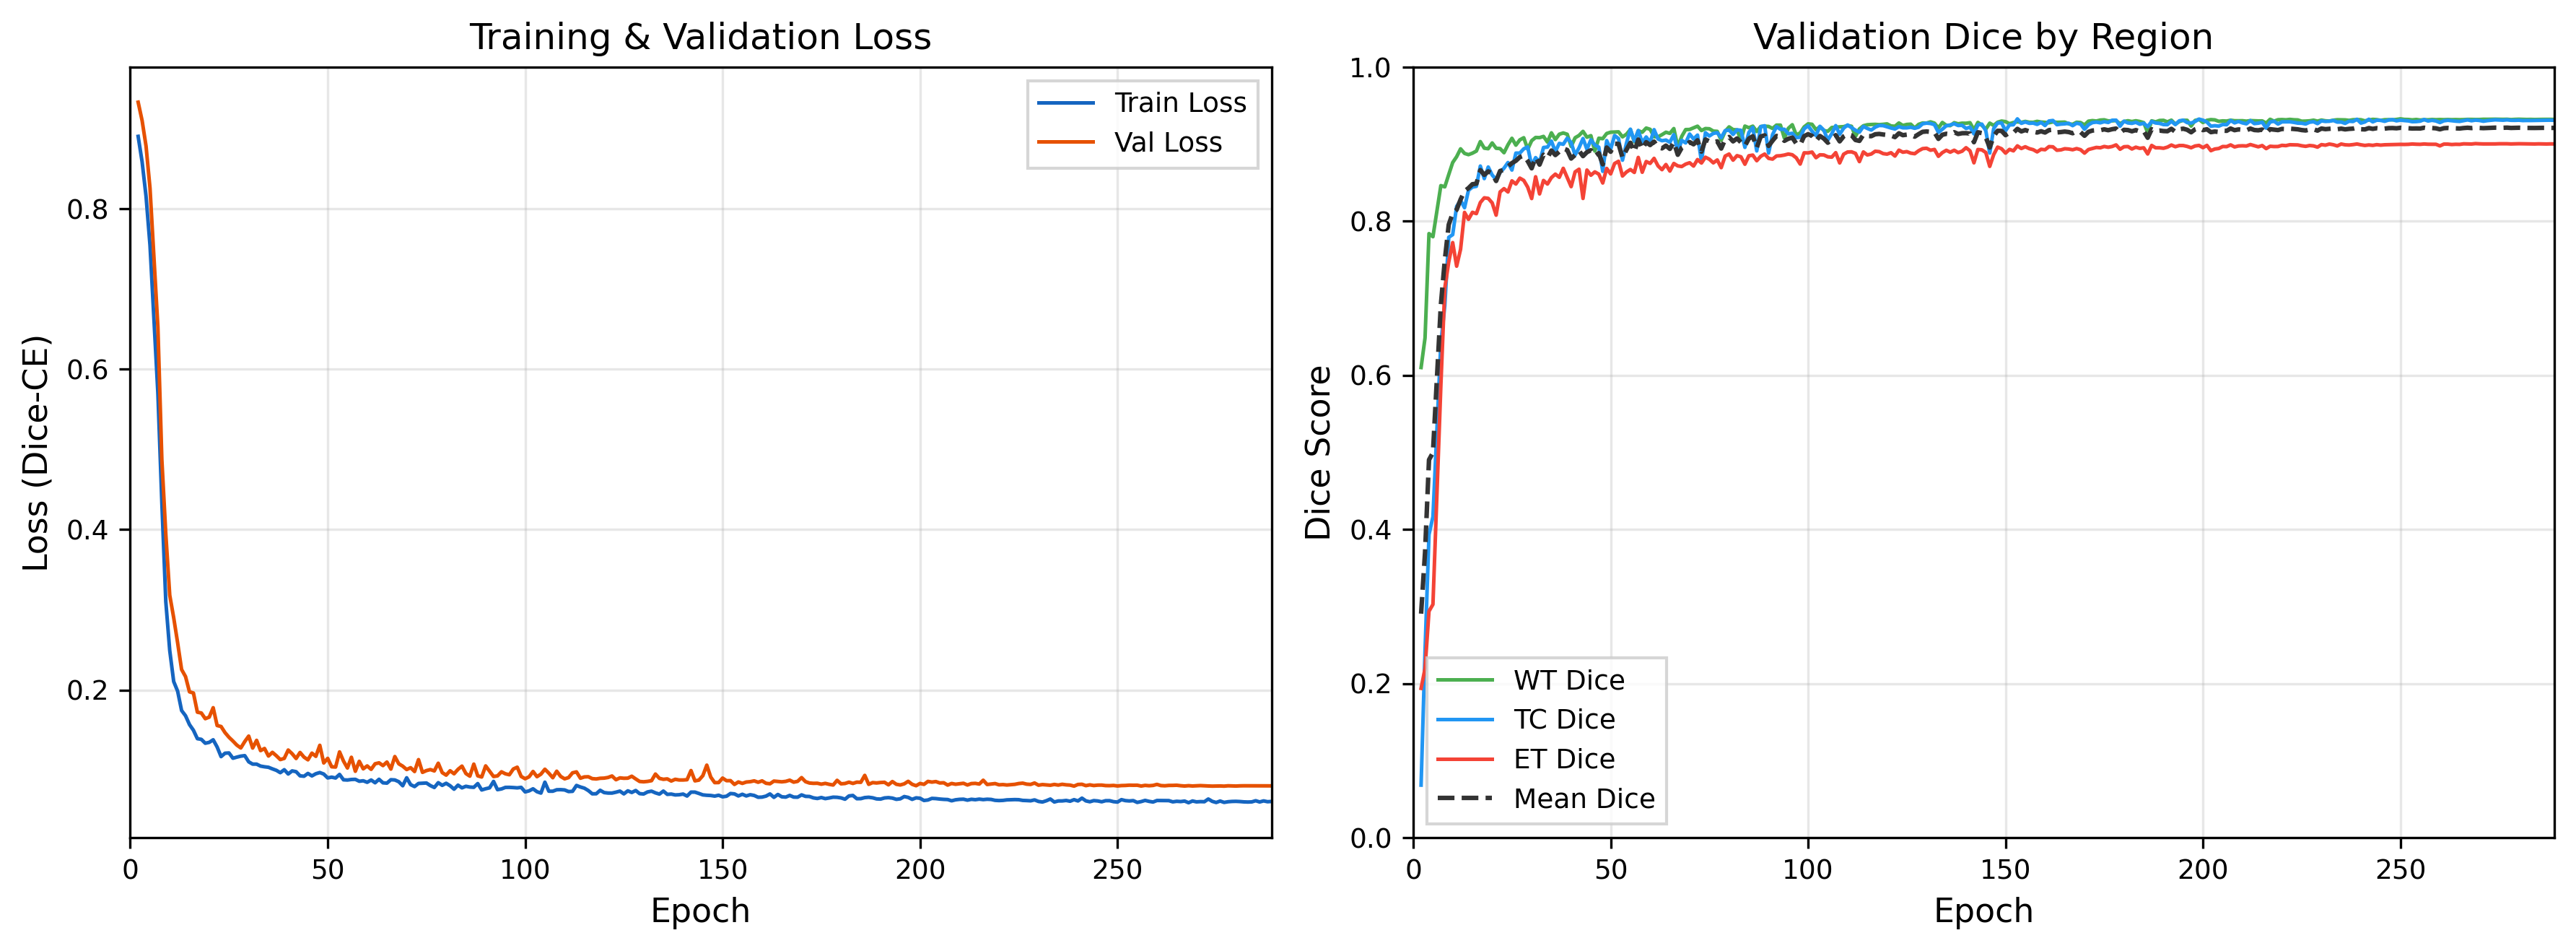

In [23]:
display(Markdown("### 7.4 已生成的 Training Curves"))

img_path = FIGURES / "training_curves.png"
if img_path.exists():
    display(Image(filename=str(img_path), width=800))
else:
    print(f"⚠️ Image not found: {img_path}")

<a id='8'></a>
## 8. 关键代码解读 Key Code Walkthrough

以下展示项目中最关键的代码片段和设计决策。

In [24]:
display(Markdown("### 8.1 标签转换 — 最核心的自定义 Transform"))

code = '''
# 文件: src/data/transforms.py (Line 52-93)
# 这是整个项目最关键的 Transform — 决定了模型的输出方式

class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    输入: seg map (1, H, W, D), 值 = 0/1/2/4
    输出: 3 个二值通道 (3, H, W, D)
    
    为什么不直接用 4-class softmax?
    → 因为 WT/TC/ET 有重叠! label=4 的体素同时属于 TC 和 ET
    → sigmoid multi-label 允许一个体素同时激活多个通道
    """
    def converter(self, img):
        tc = (img == 1) | (img == 4)              # TC: 坏死 + 增强
        wt = (img == 1) | (img == 2) | (img == 4) # WT: 坏死 + 水肿 + 增强
        et = (img == 4)                            # ET: 只有增强
        return torch.cat([tc, wt, et], dim=0)      # (3, H, W, D)
'''
print(code)

### 8.1 标签转换 — 最核心的自定义 Transform


# 文件: src/data/transforms.py (Line 52-93)
# 这是整个项目最关键的 Transform — 决定了模型的输出方式

class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    输入: seg map (1, H, W, D), 值 = 0/1/2/4
    输出: 3 个二值通道 (3, H, W, D)
    
    为什么不直接用 4-class softmax?
    → 因为 WT/TC/ET 有重叠! label=4 的体素同时属于 TC 和 ET
    → sigmoid multi-label 允许一个体素同时激活多个通道
    """
    def converter(self, img):
        tc = (img == 1) | (img == 4)              # TC: 坏死 + 增强
        wt = (img == 1) | (img == 2) | (img == 4) # WT: 坏死 + 水肿 + 增强
        et = (img == 4)                            # ET: 只有增强
        return torch.cat([tc, wt, et], dim=0)      # (3, H, W, D)



In [25]:
display(Markdown("### 8.2 训练循环核心 — AMP 混合精度"))

code = '''
# 文件: src/train.py (Line 240-266)

def train_one_epoch(*, model, loader, optimizer, loss_fn, scaler, device, ...):
    model.train()
    for batch in loader:
        # 拼接 4 模态 → (B, 4, H, W, D)
        inputs = torch.cat([batch[mod].to(device) for mod in modalities], dim=1)
        labels = batch["seg"].to(device)  # (B, 3, H, W, D) — 已转换为 3 通道
        
        optimizer.zero_grad(set_to_none=True)  # 比 zero_grad() 更高效
        
        with autocast("cuda"):          # FP16 前向传播 (省显存 + 快)
            loss = loss_fn(model(inputs), labels)  # Dice Loss
        
        scaler.scale(loss).backward()   # FP16 反向传播 (GradScaler 防下溢)
        scaler.step(optimizer)          # 更新权重 (内部转回 FP32)
        scaler.update()                 # 自适应调整 scale factor
'''
print(code)

### 8.2 训练循环核心 — AMP 混合精度


# 文件: src/train.py (Line 240-266)

def train_one_epoch(*, model, loader, optimizer, loss_fn, scaler, device, ...):
    model.train()
    for batch in loader:
        # 拼接 4 模态 → (B, 4, H, W, D)
        inputs = torch.cat([batch[mod].to(device) for mod in modalities], dim=1)
        labels = batch["seg"].to(device)  # (B, 3, H, W, D) — 已转换为 3 通道
        
        optimizer.zero_grad(set_to_none=True)  # 比 zero_grad() 更高效
        
        with autocast("cuda"):          # FP16 前向传播 (省显存 + 快)
            loss = loss_fn(model(inputs), labels)  # Dice Loss
        
        scaler.scale(loss).backward()   # FP16 反向传播 (GradScaler 防下溢)
        scaler.step(optimizer)          # 更新权重 (内部转回 FP32)
        scaler.update()                 # 自适应调整 scale factor



In [26]:
display(Markdown("### 8.3 推理后处理 — 从 3 通道 sigmoid 回到 BraTS 标签"))

code = '''
# 文件: src/infer.py (Line 170-191)

# Step 1: 模型输出 → sigmoid → 0/1
preds = (torch.sigmoid(outputs) > 0.5).numpy()  # (3, H, W, D)
tc, wt, et = preds[0], preds[1], preds[2]

# Step 2: 按优先级转回 BraTS 单标签格式
# 顺序很重要: 先填最大区域，再用小区域覆盖
label_map = np.zeros_like(tc, dtype=np.uint8)
label_map[wt == 1] = 2    # 先: ED (水肿) — 最大区域
label_map[tc == 1] = 1    # 再: NCR/NET — 覆盖水肿中属于核心的部分  
label_map[et == 1] = 4    # 最后: ET — 覆盖核心中属于增强的部分

# 结果: label=2 只剩 "在 WT 中但不在 TC 中" 的体素 = 纯水肿

# Step 3: 空间逆变换 (RAS → 原始方向 → 原始尺寸)
label_map = _reorient_ras_to_orig(label_map, orig_affine)
if label_map.shape != orig_shape:
    label_map = zoom(label_map, scale, order=0)  # nearest neighbor
'''
print(code)

### 8.3 推理后处理 — 从 3 通道 sigmoid 回到 BraTS 标签


# 文件: src/infer.py (Line 170-191)

# Step 1: 模型输出 → sigmoid → 0/1
preds = (torch.sigmoid(outputs) > 0.5).numpy()  # (3, H, W, D)
tc, wt, et = preds[0], preds[1], preds[2]

# Step 2: 按优先级转回 BraTS 单标签格式
# 顺序很重要: 先填最大区域，再用小区域覆盖
label_map = np.zeros_like(tc, dtype=np.uint8)
label_map[wt == 1] = 2    # 先: ED (水肿) — 最大区域
label_map[tc == 1] = 1    # 再: NCR/NET — 覆盖水肿中属于核心的部分  
label_map[et == 1] = 4    # 最后: ET — 覆盖核心中属于增强的部分

# 结果: label=2 只剩 "在 WT 中但不在 TC 中" 的体素 = 纯水肿

# Step 3: 空间逆变换 (RAS → 原始方向 → 原始尺寸)
label_map = _reorient_ras_to_orig(label_map, orig_affine)
if label_map.shape != orig_shape:
    label_map = zoom(label_map, scale, order=0)  # nearest neighbor



In [27]:
display(Markdown("### 8.4 Sliding Window Inference — 处理完整 3D Volume"))

code = '''
# 文件: src/infer.py (Line 161-168)

outputs = sliding_window_inference(
    inputs=inputs,               # 完整 volume (1, 4, H, W, D)
    roi_size=[128, 128, 128],    # 窗口大小 (与训练 patch 一致)
    sw_batch_size=4,             # 同时推理 4 个窗口
    predictor=model,
    overlap=0.5,                 # 50% 重叠 → step=64
    mode="gaussian",             # 高斯加权混合
)

# 工作原理:
# 1. 用 128³ 窗口在 volume 上滑动, step=64
# 2. 每个窗口独立做一次 forward pass
# 3. 重叠区域用 Gaussian 加权平均 (中心权重大, 边缘权重小)
# 4. 好处: 避免边缘伪影, 每个体素被多个窗口覆盖
'''
print(code)

### 8.4 Sliding Window Inference — 处理完整 3D Volume


# 文件: src/infer.py (Line 161-168)

outputs = sliding_window_inference(
    inputs=inputs,               # 完整 volume (1, 4, H, W, D)
    roi_size=[128, 128, 128],    # 窗口大小 (与训练 patch 一致)
    sw_batch_size=4,             # 同时推理 4 个窗口
    predictor=model,
    overlap=0.5,                 # 50% 重叠 → step=64
    mode="gaussian",             # 高斯加权混合
)

# 工作原理:
# 1. 用 128³ 窗口在 volume 上滑动, step=64
# 2. 每个窗口独立做一次 forward pass
# 3. 重叠区域用 Gaussian 加权平均 (中心权重大, 边缘权重小)
# 4. 好处: 避免边缘伪影, 每个体素被多个窗口覆盖



In [28]:
display(Markdown("### 8.5 配置文件一览"))

import yaml

for config_name in ["train_3d_unet.yaml", "infer_sliding_window.yaml", "preprocess.yaml"]:
    config_path = CONFIGS / config_name
    if config_path.exists():
        print(f"\n{'='*60}")
        print(f"📄 {config_name}")
        print(f"{'='*60}")
        print(config_path.read_text())
    else:
        print(f"⚠️ Not found: {config_path}")

### 8.5 配置文件一览


📄 train_3d_unet.yaml
# Training configuration for 3D U-Net on BraTS 2021

data:
  root_dir: /workspace/DataChallenge/data/BraTS2021_Training_Data
  modalities: [flair, t1, t1ce, t2]
  label_key: seg
  train_ratio: 0.8
  val_ratio: 0.2
  num_workers: 4
  cache_rate: 0.3

model:
  name: UNet
  spatial_dims: 3
  in_channels: 4
  out_channels: 4          # background, NCR/NET, ED, ET
  channels: [32, 64, 128, 256, 512]
  strides: [2, 2, 2, 2]
  num_res_units: 2
  norm: instance

training:
  max_epochs: 300
  batch_size: 2
  learning_rate: 1.0e-4
  weight_decay: 1.0e-5
  optimizer: AdamW
  scheduler: CosineAnnealingLR
  scheduler_params:
    T_max: 300
    eta_min: 1.0e-7

loss:
  name: DiceCELoss
  include_background: false
  to_onehot_y: true
  softmax: true

transforms:
  roi_size: [128, 128, 128]
  rand_flip_prob: 0.5
  rand_rotate_range: 0.2618  # 15 degrees
  rand_scale_range: [0.9, 1.1]
  rand_intensity_shift: 0.1
  rand_intensity_scale: 0.1

checkpointing:
  save_dir: /workspace/br

<a id='9'></a>
## 9. 总结与展望 Summary & Future Work

In [29]:
display(Markdown("""
### 9.1 项目总结

| 项目 | 详情 |
|------|------|
| **任务** | BraTS 2021 脑肿瘤分割 (WT/TC/ET 三区域) |
| **数据** | 731 例多模态 MRI, 80/20 split |
| **模型** | 3D U-Net (19.2M params), MONAI 框架 |
| **训练** | 289 epochs, ~21.4h, AdamW + CosineAnnealing + AMP |
| **结果** | **Overall Dice = 0.913**, WT=0.925, TC=0.921, ET=0.891 |

### 9.2 可能的改进方向

| 方向 | 方法 | 预期提升 | 难度 |
|------|------|---------|------|
| **推理增强** | Test-Time Augmentation (翻转+取平均) | +0.5~1.5% Dice | 低 |
| **模型集成** | 多 fold / 多 seed ensemble | +1~2% Dice | 低 |
| **后处理** | Connected Component Analysis (去除孤立假阳性) | 大幅降低 HD95 | 低 |
| **Loss** | Dice + CrossEntropy 组合 | 稳定早期训练 | 低 |
| **Deep Supervision** | 解码器每层都加 loss | +0.5~1% Dice | 中 |
| **更强模型** | nnU-Net / Swin UNETR / SegResNet | +1~3% Dice | 中-高 |
| **数据增强** | MixUp, CutMix (需适配 3D) | +0.5% Dice | 中 |

### 9.3 从 baseline 到比赛方案的差距

本项目是一个**扎实的 single-model baseline**。BraTS 比赛冠军方案通常还包含:
- 5-fold cross-validation + ensemble
- TTA (8种翻转 × 多个 scale)
- 自动超参搜索 (nnU-Net 的自动配置)
- 精细后处理 (region-based refinement)
- 更大的 patch size (如 192³ 或 224³)
"""))


### 9.1 项目总结

| 项目 | 详情 |
|------|------|
| **任务** | BraTS 2021 脑肿瘤分割 (WT/TC/ET 三区域) |
| **数据** | 731 例多模态 MRI, 80/20 split |
| **模型** | 3D U-Net (19.2M params), MONAI 框架 |
| **训练** | 289 epochs, ~21.4h, AdamW + CosineAnnealing + AMP |
| **结果** | **Overall Dice = 0.913**, WT=0.925, TC=0.921, ET=0.891 |

### 9.2 可能的改进方向

| 方向 | 方法 | 预期提升 | 难度 |
|------|------|---------|------|
| **推理增强** | Test-Time Augmentation (翻转+取平均) | +0.5~1.5% Dice | 低 |
| **模型集成** | 多 fold / 多 seed ensemble | +1~2% Dice | 低 |
| **后处理** | Connected Component Analysis (去除孤立假阳性) | 大幅降低 HD95 | 低 |
| **Loss** | Dice + CrossEntropy 组合 | 稳定早期训练 | 低 |
| **Deep Supervision** | 解码器每层都加 loss | +0.5~1% Dice | 中 |
| **更强模型** | nnU-Net / Swin UNETR / SegResNet | +1~3% Dice | 中-高 |
| **数据增强** | MixUp, CutMix (需适配 3D) | +0.5% Dice | 中 |

### 9.3 从 baseline 到比赛方案的差距

本项目是一个**扎实的 single-model baseline**。BraTS 比赛冠军方案通常还包含:
- 5-fold cross-validation + ensemble
- TTA (8种翻转 × 多个 scale)
- 自动超参搜索 (nnU-Net 的自动配置)
- 精细后处理 (region-based refinement)
- 更大的 patch size (如 192³ 或 224³)


In [30]:
print("\n" + "=" * 60)
print("  ✅ Notebook 结束")
print("  本 notebook 所有内容均可在本地无 GPU 环境运行")
print("  数据来源: reports/results.csv + training_history.json")
print("  图片来源: reports/figures/ + outputs/*/")
print("=" * 60)


  ✅ Notebook 结束
  本 notebook 所有内容均可在本地无 GPU 环境运行
  数据来源: reports/results.csv + training_history.json
  图片来源: reports/figures/ + outputs/*/
